In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\YoeriA\AppData\Local\Temp\ipykernel_5652\3434716596.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# exploration of tables

In [2]:
# get names of data tables
files = os.listdir('./data/')
csv_files = [file for file in files if file.endswith('.csv')]
table_names = [file.split('.')[0] for file in csv_files]
table_names

['assessments',
 'courses',
 'studentAssessment',
 'studentInfo',
 'studentRegistration',
 'studentVle',
 'vle']

In [3]:
# create dict of DataFrames for each table 
dfs = {}

for table_name in table_names:
    dfs[f'{table_name}'] = pd.read_csv(f'./data/{table_name}.csv')


In [4]:
print("SIZE OF TABLES \n")

for table_name, df in dfs.items():
    print(table_name, df.shape)

SIZE OF TABLES 

assessments (206, 6)
courses (22, 3)
studentAssessment (173912, 5)
studentInfo (32593, 12)
studentRegistration (32593, 5)
studentVle (10655280, 6)
vle (6364, 6)


## courses

code_module – code name of the module, which serves as the identifier.

code_presentation – code name of the presentation. It consists of the year and “B” for the presentation starting in February and “J” for the presentation starting in October.

length - length of the module-presentation in days.

In [5]:
df_courses = dfs['courses'].copy()
df_courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


In [6]:
# check for duplicates
df_courses.duplicated().sum()


0

In [7]:
# check column types
df_courses.dtypes

code_module                   object
code_presentation             object
module_presentation_length     int64
dtype: object

In [8]:
# split code_presentation into year and start_month
df_courses[['year', 'start_month']] = df_courses['code_presentation'].str.extract(r'(\d{4})([A-Za-z])')
df_courses.loc[df_courses['start_month'] == 'J', 'start_month'] = 'october'
df_courses.loc[df_courses['start_month'] == 'B', 'start_month'] = 'february'
df_courses.head()



,code_module,code_presentation,module_presentation_length,year,start_month
0,AAA,2013J,268,2013,october
1,AAA,2014J,269,2014,october
2,BBB,2013J,268,2013,october
3,BBB,2014J,262,2014,october
4,BBB,2013B,240,2013,february


In [9]:
#check missing data
df_courses.isna().sum()

code_module                   0
code_presentation             0
module_presentation_length    0
year                          0
start_month                   0
dtype: int64

In [10]:
# take a look at quantitative variables
df_courses.describe()


,module_presentation_length
count,22.000000
mean,255.545455
std,13.654677
min,234.000000
25%,241.000000
50%,261.500000
75%,268.000000
max,269.000000


Text(0, 0.5, 'Number of courses')

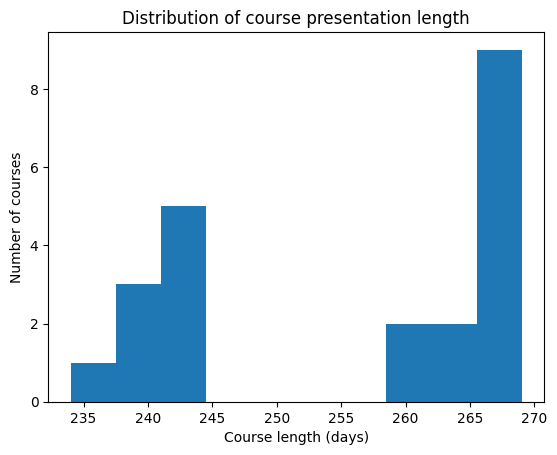

In [11]:
plt.hist(df_courses['module_presentation_length'], bins=None)
plt.title('Distribution of course presentation length')
plt.xlabel('Course length (days)')
plt.ylabel('Number of courses')

In [12]:
# take a look at qualitative variables ; note, year is considered categorical here
df_courses.describe(include='object')

,code_module,code_presentation,year,start_month
count,22,22,22,22
unique,7,4,2,2
top,BBB,2014J,2014,october
freq,4,7,13,13


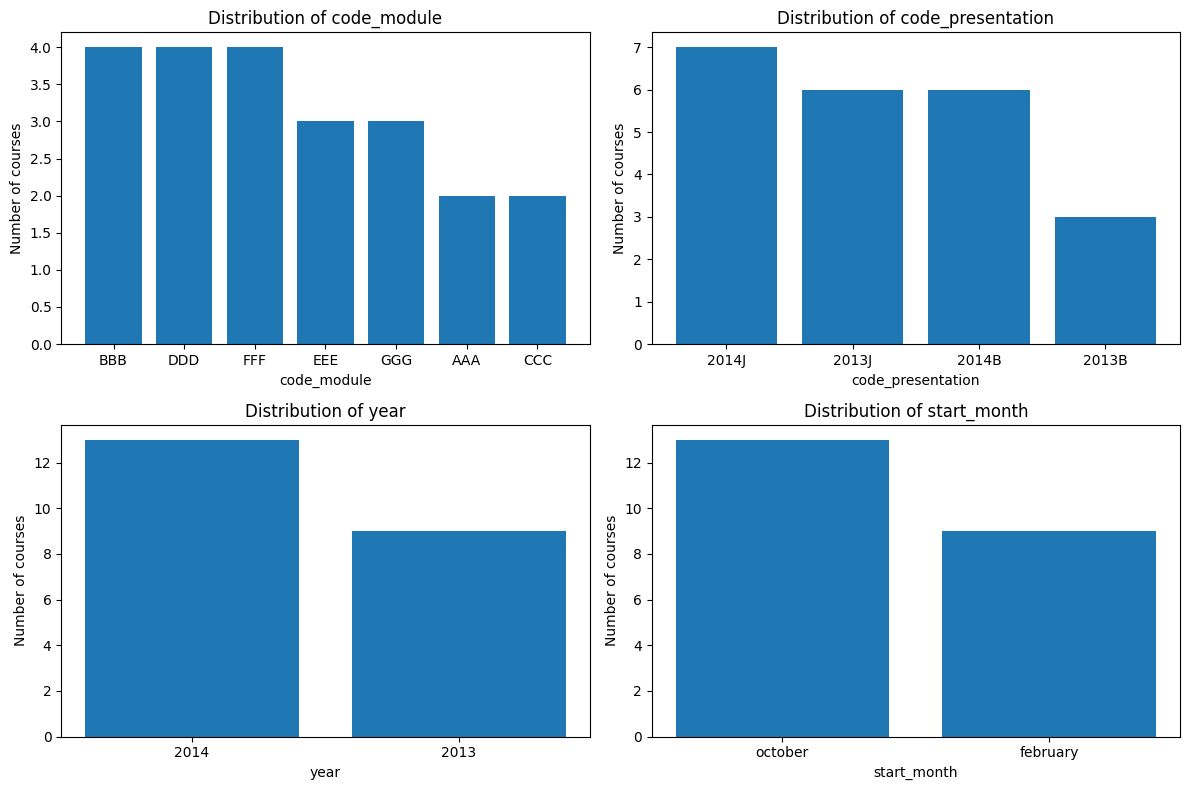

In [13]:
cat_variables = ['code_module', 'code_presentation', 'year', 'start_month']
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()


for i, variable in enumerate(cat_variables):
    data = df_courses[f'{variable}'].value_counts()
    ax = axes[i]

    ax.bar(data.index, data)
    ax.set_title(f'Distribution of {variable}')
    ax.set_xlabel(f'{variable}')
    ax.set_ylabel('Number of courses')


plt.tight_layout()


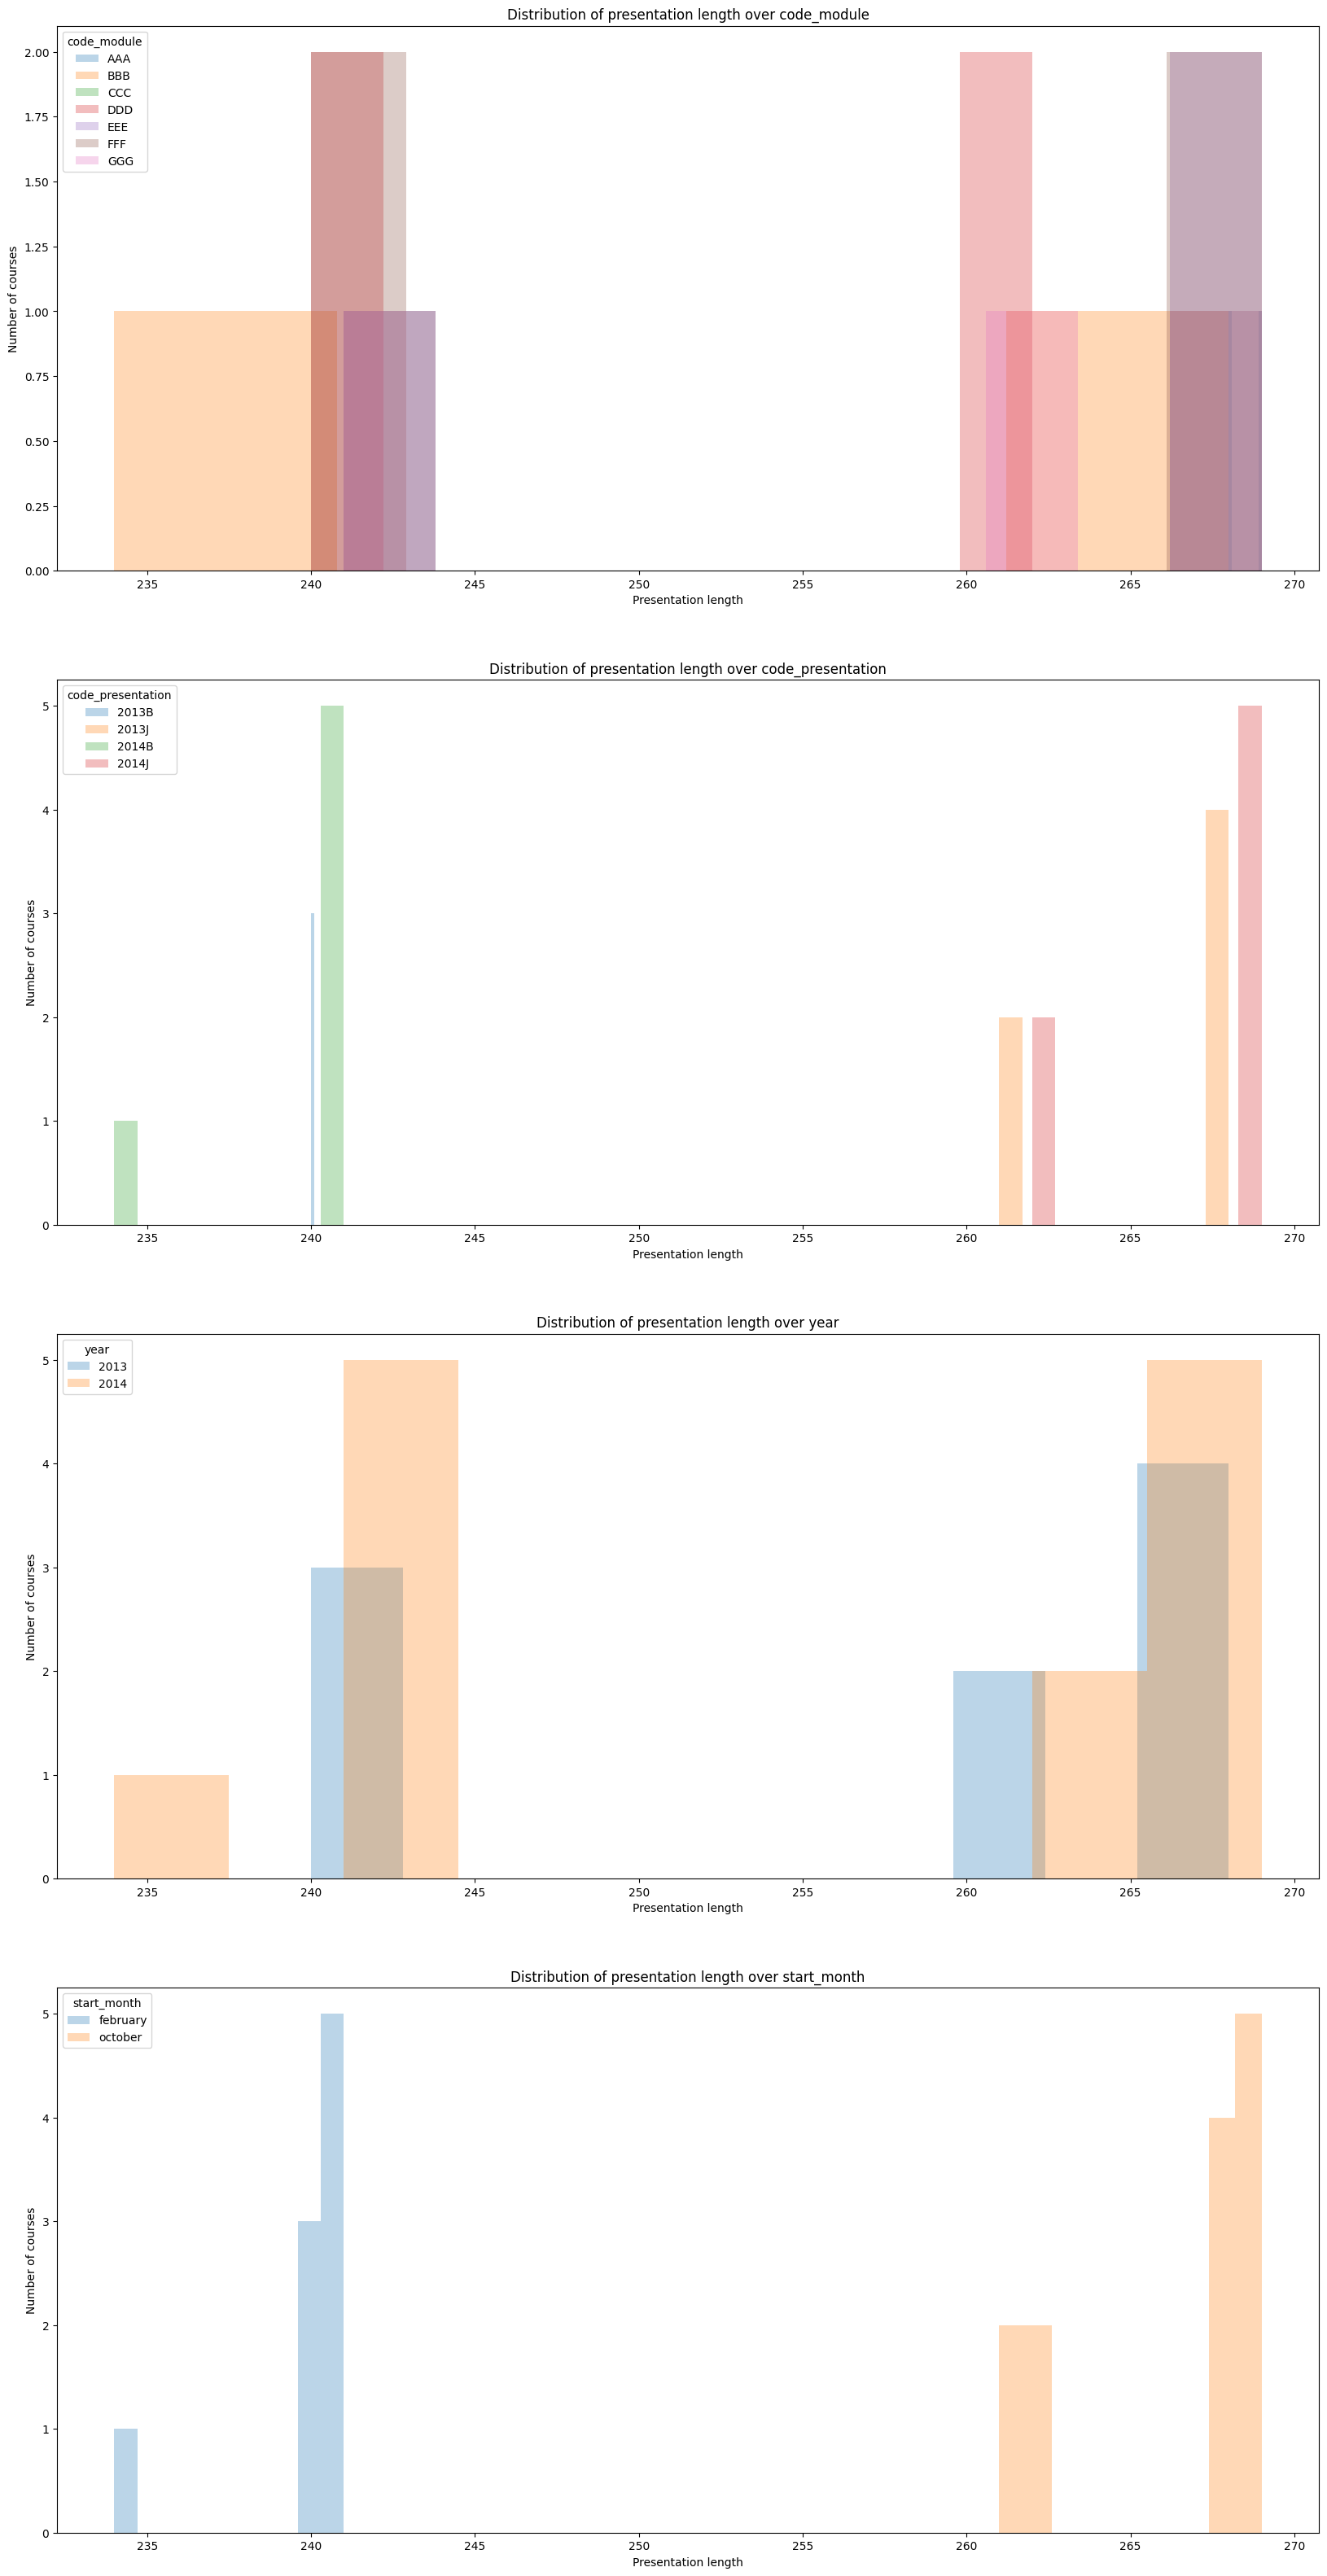

In [14]:
# is course length dependent on the categorical variables?
fig, axes = plt.subplots(4, 1, figsize=(20, 40))
axes = axes.flatten()

for i, variable in enumerate(cat_variables):
    ax = axes[i]
    for group_name, group_data in df_courses.groupby(variable):
        ax.hist(group_data['module_presentation_length'], bins=None, alpha=0.3, label=group_name)
        ax.set_title(f'Distribution of presentation length over {variable}')
        ax.set_xlabel('Presentation length')
        ax.set_ylabel('Number of courses')        
        ax.legend(title=f'{variable}')


->  Courses starting in February are clearly shorter than those starting in October.

->  No clear difference for year

->  Code presentation is a combination of year and start month

->  Code_module is not clearly visible in these charts

In [15]:
# create interactive histogram for the relationship between presentation length and code_module
import plotly.express as px

fig = px.histogram(df_courses, x='module_presentation_length', color='code_module', marginal='box', nbins=30,
                   labels={'module_presentation_length': 'Course length (days)', 'code_module': 'Code Module'},
                   title='Distribution of Course Presentation Length by Code Module')

fig.show()

d:\OneDrive - Ortec B.V\do Python\Edudash\venv\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


->  Except for AAA, all courses seem to have quite a variable presentation length

In [16]:
# create interactive histogram for the relationship between presentation length and code_module per start_month

from plotly.subplots import make_subplots

# split df per start month
df = df_courses[df_courses['start_month'] == 'february']
df_oct = df_courses[df_courses['start_month'] == 'october']

# define order for uniform color use in legend
category_order = df_courses['code_module'].sort_values().unique()
color_sequence = px.colors.qualitative.Plotly

# create charts for February and October
fig_feb = px.histogram(df, x='module_presentation_length', color='code_module', nbins=30,
                       labels={'module_presentation_length': 'Course length (days)', 'code_module': 'Code Module'},
                       title='Distribution of Course Presentation Length by Code Module (start February)',
                       color_discrete_sequence=color_sequence,
                       category_orders={'code_module': category_order},)


fig_oct = px.histogram(df_oct, x='module_presentation_length', color='code_module', nbins=30,
                       labels={'module_presentation_length': 'Course length (days)', 'code_module': 'Code Module'},
                       title='Distribution of Course Presentation Length by Code Module (start October)',
                       color_discrete_sequence=color_sequence,
                       category_orders={'code_module': category_order})

# create subplot and add figures
fig = make_subplots(rows=2, cols=1, subplot_titles=('Start February', 'Start October'),
                    horizontal_spacing=0.1)

for trace in fig_feb.data:
    fig.add_trace(trace, row=1, col=1)

for trace in fig_oct.data:
    fig.add_trace(trace, row=2, col=1)

# set fixed x axis limits for easy comparison
xmin = min(df_courses['module_presentation_length'])-2
xmax = max(df_courses['module_presentation_length'])+2
fig.update_xaxes(range=[xmin, xmax], row=1, col=1)
fig.update_xaxes(range=[xmin, xmax], row=2, col=1)

fig.update_layout(
    showlegend=True,
    height=1000
)



d:\OneDrive - Ortec B.V\do Python\Edudash\venv\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

d:\OneDrive - Ortec B.V\do Python\Edudash\venv\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



->  variability in course length within code_module is explained by start month

## assessments

code_module – identification code of the module, to which the assessment belongs.

code_presentation - identification code of the presentation, to which the assessment belongs.

id_assessment – identification number of the assessment.

assessment_type – type of assessment. Three types of assessments exist: Tutor Marked Assessment (TMA), Computer Marked Assessment (CMA) and Final Exam (Exam).

date – information about the final submission date of the assessment calculated as the number of days since the start of the module-presentation. The starting date of the presentation has number 0 (zero).

weight - weight of the assessment in %. Typically, Exams are treated separately and have the weight 100%; the sum of all other assessments is 100%.

In [17]:
df_assessments = dfs['assessments'].copy()
df_assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


In [18]:
# check for duplicates
df_assessments.duplicated().sum()


0

In [19]:
# check column types
df_assessments.dtypes

code_module           object
code_presentation     object
id_assessment          int64
assessment_type       object
date                 float64
weight               float64
dtype: object

In [20]:
#check missing data
df_assessments.isna().sum()

code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64

In [21]:
# check rows with missing data
df_assessments[df_assessments['date'].isna()]

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,NaN,100.0
11,AAA,2014J,1763,Exam,NaN,100.0
23,BBB,2013B,14990,Exam,NaN,100.0
35,BBB,2013J,15002,Exam,NaN,100.0
47,BBB,2014B,15014,Exam,NaN,100.0
53,BBB,2014J,15025,Exam,NaN,100.0
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0


In [22]:
# take a look at quantitative variables
df_assessments.describe()

,id_assessment,date,weight
count,206.000000,195.000000,206.000000
mean,26473.975728,145.005128,20.873786
std,10098.625521,76.001119,30.384224
min,1752.000000,12.000000,0.000000
25%,15023.250000,71.000000,0.000000
50%,25364.500000,152.000000,12.500000
75%,34891.750000,222.000000,24.250000
max,40088.000000,261.000000,100.000000


Text(0, 0.5, 'Number of assessments')

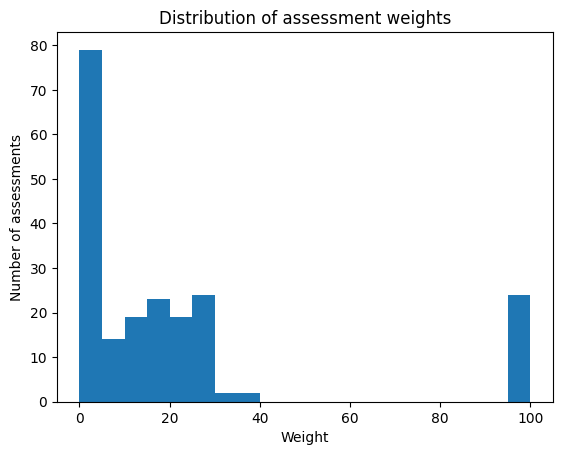

In [23]:
plt.hist(df_assessments['weight'], bins=20)
plt.title('Distribution of assessment weights')
plt.xlabel('Weight')
plt.ylabel('Number of assessments')

In [24]:
# check wether weights are always equal

modules = df_assessments['code_module'].unique()
presentations = df_assessments['code_presentation'].unique()
total_weights = {}


for module in modules:
    for presentation in presentations:
        module_presentation = module + '-' + presentation
        total_weights[module_presentation] = df_assessments[(df_assessments['code_module']==module) & (df_assessments['code_presentation']==presentation)].weight.sum()

total_weights

{'AAA-2013J': 200.0,
 'AAA-2014J': 200.0,
 'AAA-2013B': 0.0,
 'AAA-2014B': 0.0,
 'BBB-2013J': 200.0,
 'BBB-2014J': 200.0,
 'BBB-2013B': 200.0,
 'BBB-2014B': 200.0,
 'CCC-2013J': 0.0,
 'CCC-2014J': 300.0,
 'CCC-2013B': 0.0,
 'CCC-2014B': 300.0,
 'DDD-2013J': 200.0,
 'DDD-2014J': 200.0,
 'DDD-2013B': 200.0,
 'DDD-2014B': 200.0,
 'EEE-2013J': 200.0,
 'EEE-2014J': 200.0,
 'EEE-2013B': 0.0,
 'EEE-2014B': 200.0,
 'FFF-2013J': 200.0,
 'FFF-2014J': 200.0,
 'FFF-2013B': 200.0,
 'FFF-2014B': 200.0,
 'GGG-2013J': 100.0,
 'GGG-2014J': 100.0,
 'GGG-2013B': 0.0,
 'GGG-2014B': 100.0}

-> weights don't always add up to 100

In [25]:
# normalise weights as percentage of total
module_presentations = df_assessments['code_module'] + '-' + df_assessments['code_presentation']

mapped_weights = module_presentations.map(total_weights)

df_assessments['weight_norm'] = df_assessments['weight'] / mapped_weights
df_assessments['weight_norm']

0      0.05
1      0.10
2      0.10
3      0.10
4      0.15
       ... 
201    0.00
202    0.00
203    0.00
204    0.00
205    1.00
Name: weight_norm, Length: 206, dtype: float64

In [26]:
# check whether weights are correctly normalised
total_weights_norm = {}

for module in modules:
    for presentation in presentations:
        module_presentation = module + '-' + presentation
        total_weights_norm[module_presentation] = df_assessments[(df_assessments['code_module']==module) & (df_assessments['code_presentation']==presentation)].weight_norm.sum()

total_weights_norm

{'AAA-2013J': 1.0,
 'AAA-2014J': 1.0,
 'AAA-2013B': 0.0,
 'AAA-2014B': 0.0,
 'BBB-2013J': 0.9999999999999999,
 'BBB-2014J': 1.0,
 'BBB-2013B': 0.9999999999999999,
 'BBB-2014B': 0.9999999999999999,
 'CCC-2013J': 0.0,
 'CCC-2014J': 1.0,
 'CCC-2013B': 0.0,
 'CCC-2014B': 1.0,
 'DDD-2013J': 1.0,
 'DDD-2014J': 1.0,
 'DDD-2013B': 1.0,
 'DDD-2014B': 1.0,
 'EEE-2013J': 1.0,
 'EEE-2014J': 1.0,
 'EEE-2013B': 0.0,
 'EEE-2014B': 1.0,
 'FFF-2013J': 1.0,
 'FFF-2014J': 1.0,
 'FFF-2013B': 1.0,
 'FFF-2014B': 1.0,
 'GGG-2013J': 1.0,
 'GGG-2014J': 1.0,
 'GGG-2013B': 0.0,
 'GGG-2014B': 1.0}

-> all weights are normalised for courses with assessments

Text(0, 0.5, 'Number of assessments')

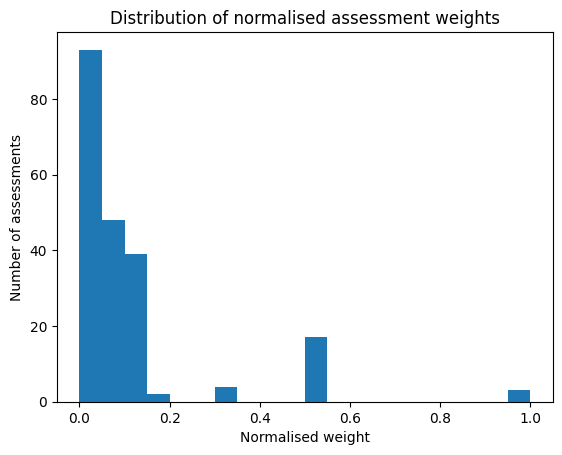

In [27]:
plt.hist(df_assessments['weight_norm'], bins=20)
plt.title('Distribution of normalised assessment weights')
plt.xlabel('Normalised weight')
plt.ylabel('Number of assessments')

Text(0, 0.5, 'Number of assessments')

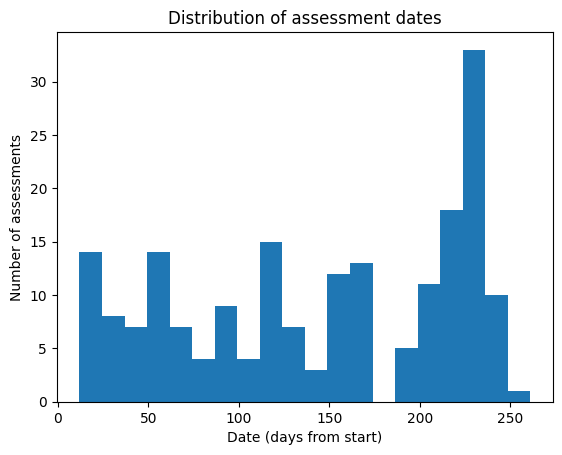

In [28]:
plt.hist(df_assessments['date'], bins=20)
plt.title('Distribution of assessment dates')
plt.xlabel('Date (days from start)')
plt.ylabel('Number of assessments')

In [29]:
# normalise date based on course length

# merge df_courses into df_assessments ; this makes df_courses obsolete
df_assessments = df_assessments.merge(df_courses,
                                      on=['code_module', 'code_presentation'],
                                      how='left')

df_assessments

,code_module,code_presentation,id_assessment,assessment_type,date,weight,weight_norm,module_presentation_length,year,start_month
0,AAA,2013J,1752,TMA,19.0,10.0,0.05,268,2013,october
1,AAA,2013J,1753,TMA,54.0,20.0,0.10,268,2013,october
2,AAA,2013J,1754,TMA,117.0,20.0,0.10,268,2013,october
3,AAA,2013J,1755,TMA,166.0,20.0,0.10,268,2013,october
4,AAA,2013J,1756,TMA,215.0,30.0,0.15,268,2013,october
...,...,...,...,...,...,...,...,...,...,...
201,GGG,2014J,37443,CMA,229.0,0.0,0.00,269,2014,october
202,GGG,2014J,37435,TMA,61.0,0.0,0.00,269,2014,october
203,GGG,2014J,37436,TMA,124.0,0.0,0.00,269,2014,october
204,GGG,2014J,37437,TMA,173.0,0.0,0.00,269,2014,october


In [30]:
df_assessments['date_norm'] = df_assessments['date']/df_assessments['module_presentation_length']
df_assessments['date_norm']

0      0.070896
1      0.201493
2      0.436567
3      0.619403
4      0.802239
         ...   
201    0.851301
202    0.226766
203    0.460967
204    0.643123
205    0.851301
Name: date_norm, Length: 206, dtype: float64

Text(0, 0.5, 'Number of assessments')

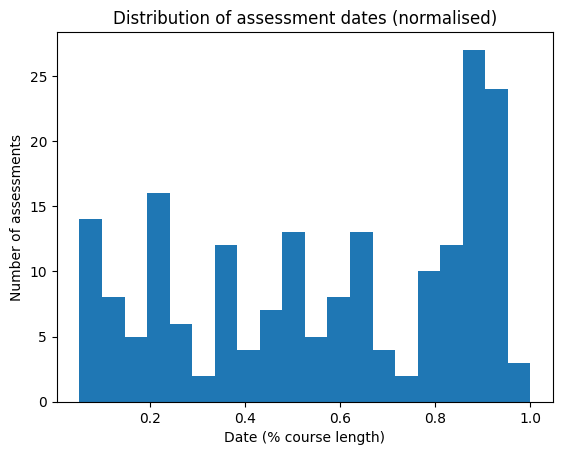

In [31]:
plt.hist(df_assessments['date_norm'], bins=20)
plt.title('Distribution of assessment dates (normalised)')
plt.xlabel('Date (% course length)')
plt.ylabel('Number of assessments')

In [32]:
# let's take a loot at the relationship between normalised date and normalised weight for the different assessment types
fig = px.scatter(df_assessments, x='date_norm', y='weight_norm', color='assessment_type', title='Scatter Plot with Color Grouping')
fig.show()

d:\OneDrive - Ortec B.V\do Python\Edudash\venv\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



-> We see the importance of exams and TMA also in the scatter plot.

-> Exams are always done at the end of a presentation. TMA stops around the same time exams start. CMA runs the whole year.

-> Exams always count for 50% or 100% of the total score.

In [33]:
# take a look at qualitative variables ; note, year is considered categorical here
df_assessments.describe(include='object')


,code_module,code_presentation,assessment_type,year,start_month
count,206,206,206,206,206
unique,7,4,3,2,2
top,FFF,2014J,TMA,2014,october
freq,52,57,106,114,110


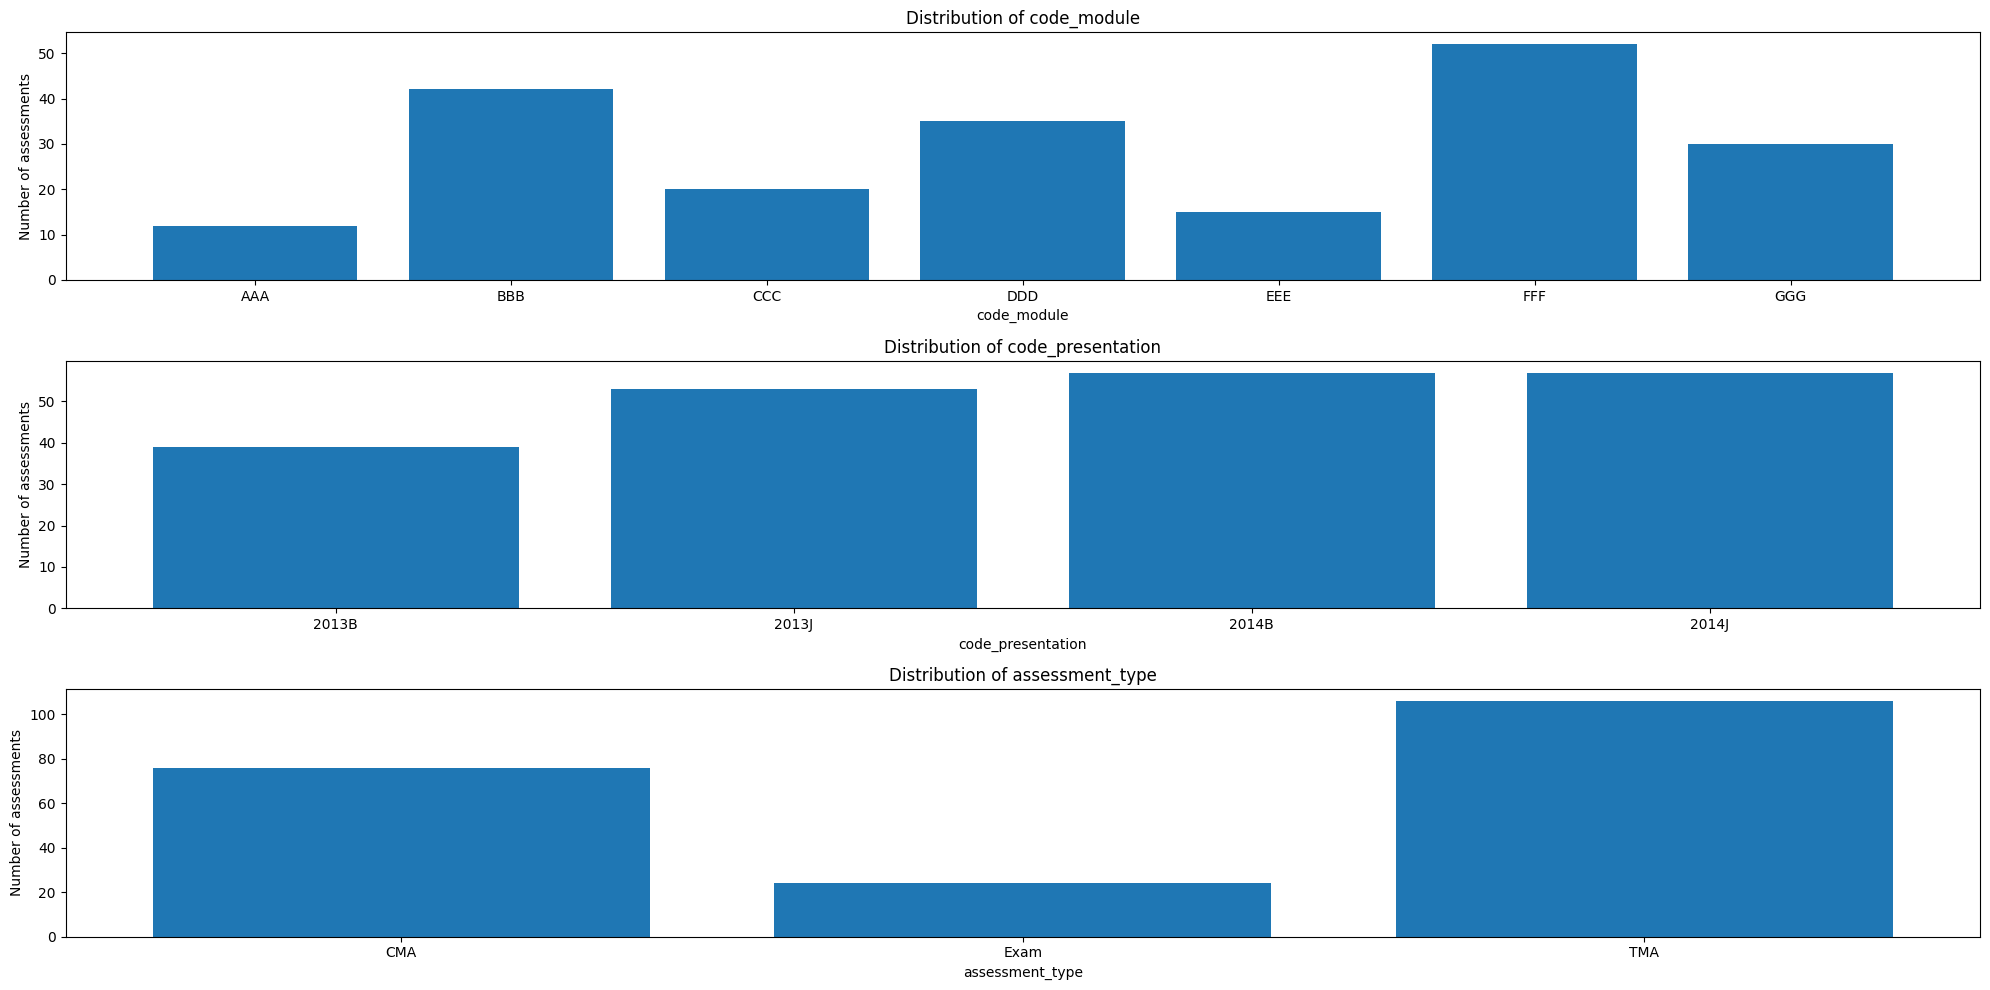

In [34]:
cat_variables = ['code_module', 'code_presentation', 'assessment_type']

fig, axes = plt.subplots(3, 1, figsize=(20, 10))
axes = axes.flatten()


for i, variable in enumerate(cat_variables):
    data = df_assessments[f'{variable}'].value_counts().sort_index()
    ax = axes[i]

    ax.bar(data.index, data)
    ax.set_title(f'Distribution of {variable}')
    ax.set_xlabel(f'{variable}')
    ax.set_ylabel('Number of assessments')

plt.tight_layout()

In [35]:
# how important are the different types of assessment when taking the normalised weight into account?
weights_norm_grouped = df_assessments.groupby('assessment_type')['weight_norm'].sum()
weights_norm_grouped



assessment_type
CMA      0.366667
Exam    12.833333
TMA      8.800000
Name: weight_norm, dtype: float64

In [36]:
total_weight = weights_norm_grouped.sum()
weights_norm_grouped_norm = weights_norm_grouped/total_weight
weights_norm_grouped_norm.round(2)*100

assessment_type
CMA      2.0
Exam    58.0
TMA     40.0
Name: weight_norm, dtype: float64

-> 58% of the assessments scores are dependent on exams ; CMA counts for only 2% 

## VLE

id_site – an identification number of the material.

code_module – an identification code for module.

code_presentation - the identification code of presentation.

activity_type – the role associated with the module material.

week_from – the week from which the material is planned to be used.

week_to – week until which the material is planned to be used.

In [37]:
df_vle = dfs['vle'].copy()
df_vle

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN
...,...,...,...,...,...,...
6359,897063,GGG,2014J,resource,NaN,NaN
6360,897109,GGG,2014J,resource,NaN,NaN
6361,896965,GGG,2014J,oucontent,NaN,NaN
6362,897060,GGG,2014J,resource,NaN,NaN


In [38]:
# check for duplicates
df_vle.duplicated().sum()


0

In [39]:
# check column types
df_vle.dtypes

id_site                int64
code_module           object
code_presentation     object
activity_type         object
week_from            float64
week_to              float64
dtype: object

In [40]:
df_vle.isna().sum()

id_site                 0
code_module             0
code_presentation       0
activity_type           0
week_from            5243
week_to              5243
dtype: int64

In [41]:
df_vle.describe()

,id_site,week_from,week_to
count,6.364000e+03,1121.000000,1121.000000
mean,7.260991e+05,15.204282,15.214987
std,1.283151e+05,8.792865,8.779806
min,5.267210e+05,0.000000,0.000000
25%,6.615928e+05,8.000000,8.000000
50%,7.300965e+05,15.000000,15.000000
75%,8.140162e+05,22.000000,22.000000
max,1.077905e+06,29.000000,29.000000


In [42]:
# look at how long vle are supposed to be used for the materials who hae values for week_from and week_to
(df_vle['week_to']-df_vle['week_from']).value_counts()

0.0    1111
1.0       8
2.0       2
Name: count, dtype: int64

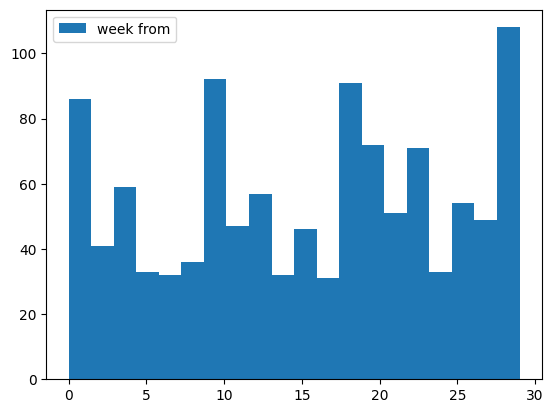

In [43]:
plt.hist(df_vle['week_from'], bins = 20, label='week from')
plt.legend()

-> this shape looks a lot like the distribution of assessments over the course length

In [44]:
df_vle.describe(include='object')

,code_module,code_presentation,activity_type
count,6364,6364,6364
unique,7,4,20
top,FFF,2013J,resource
freq,1967,1772,2660


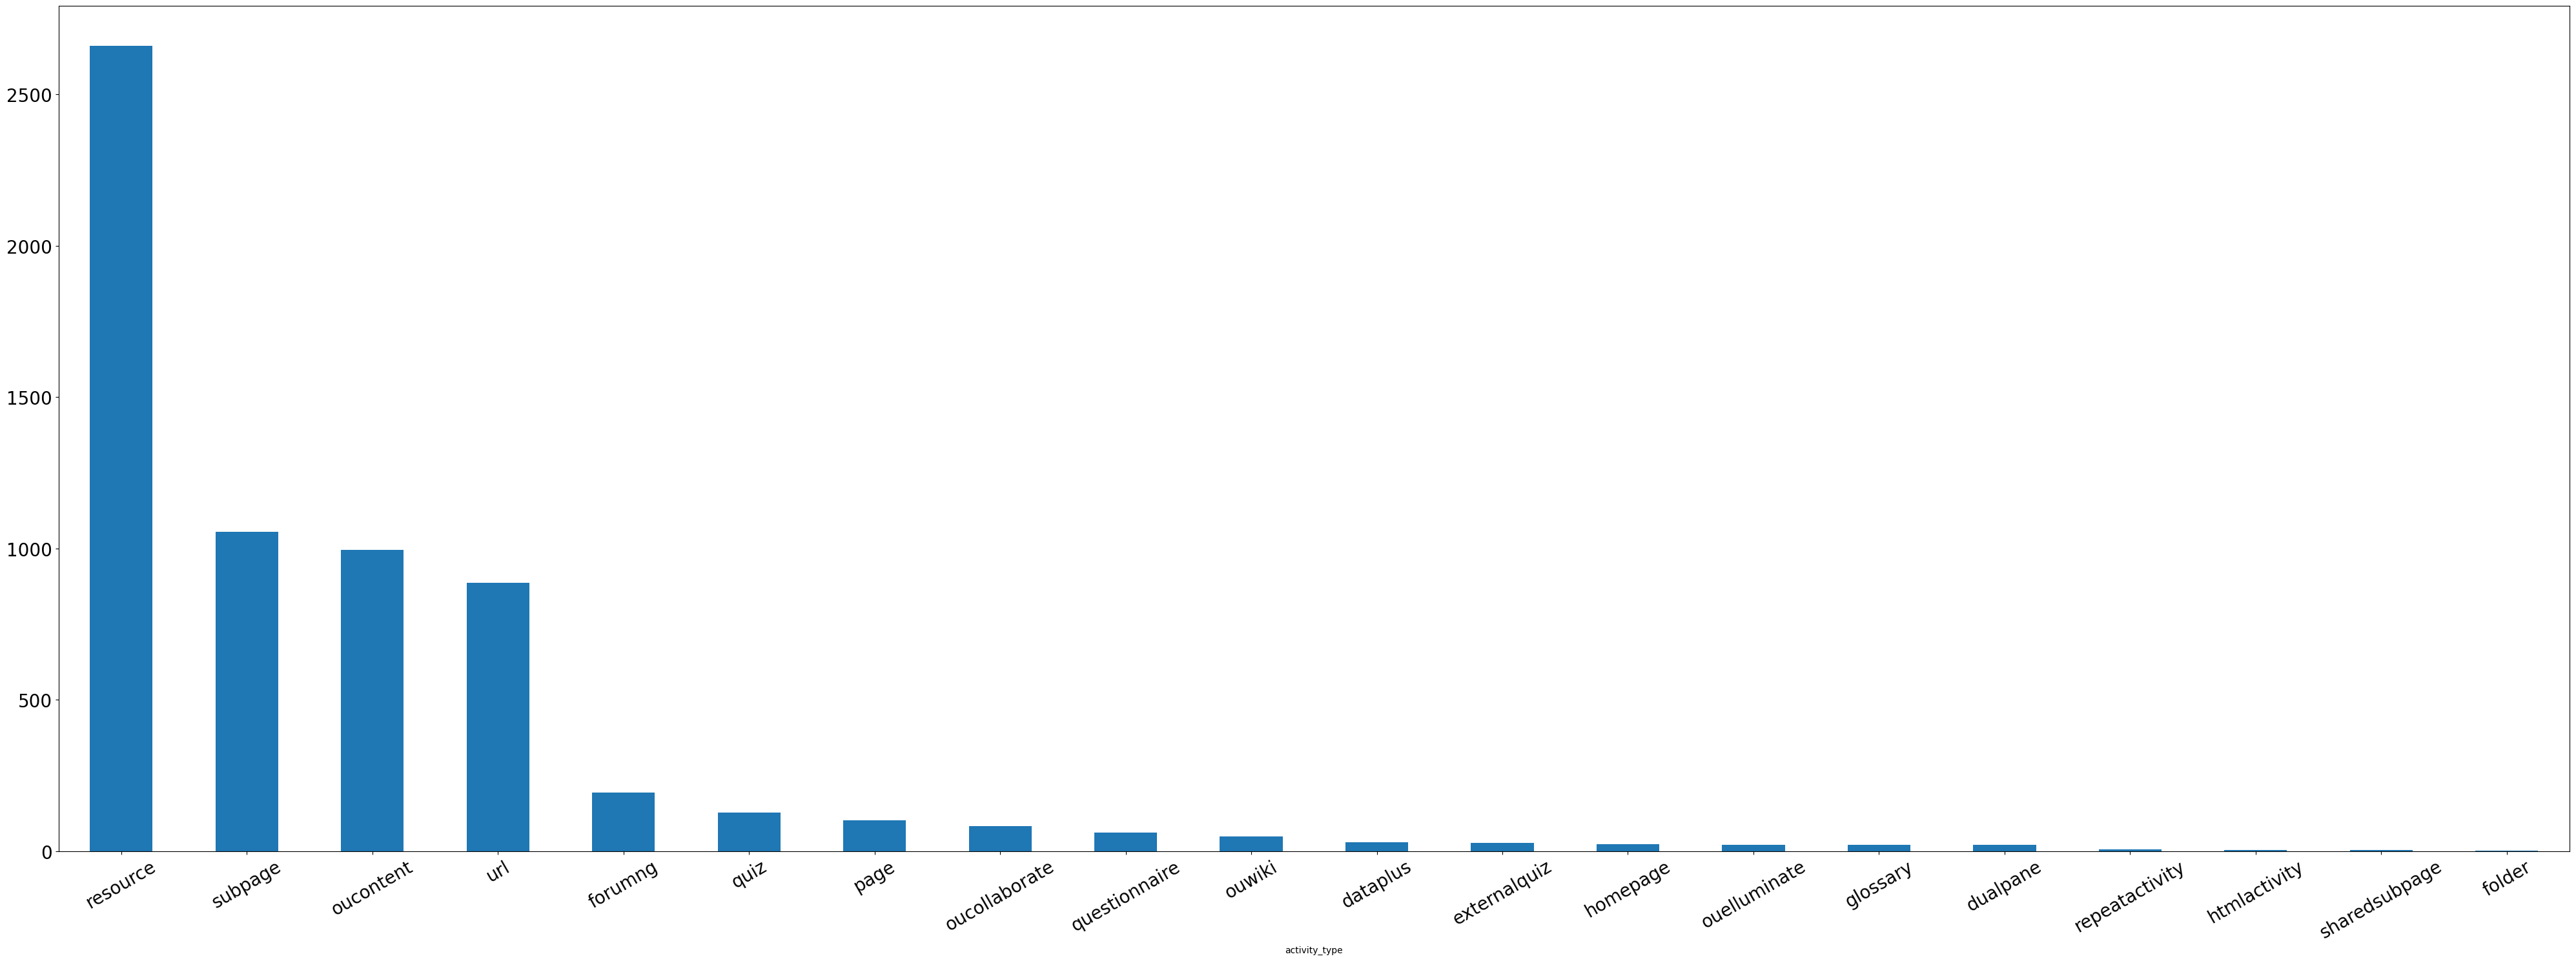

In [45]:
# chart of distribution activity_type 
df_vle['activity_type'].value_counts().plot(kind='bar', figsize=(40, 15), fontsize=20, rot=30)

plt.tight_layout()

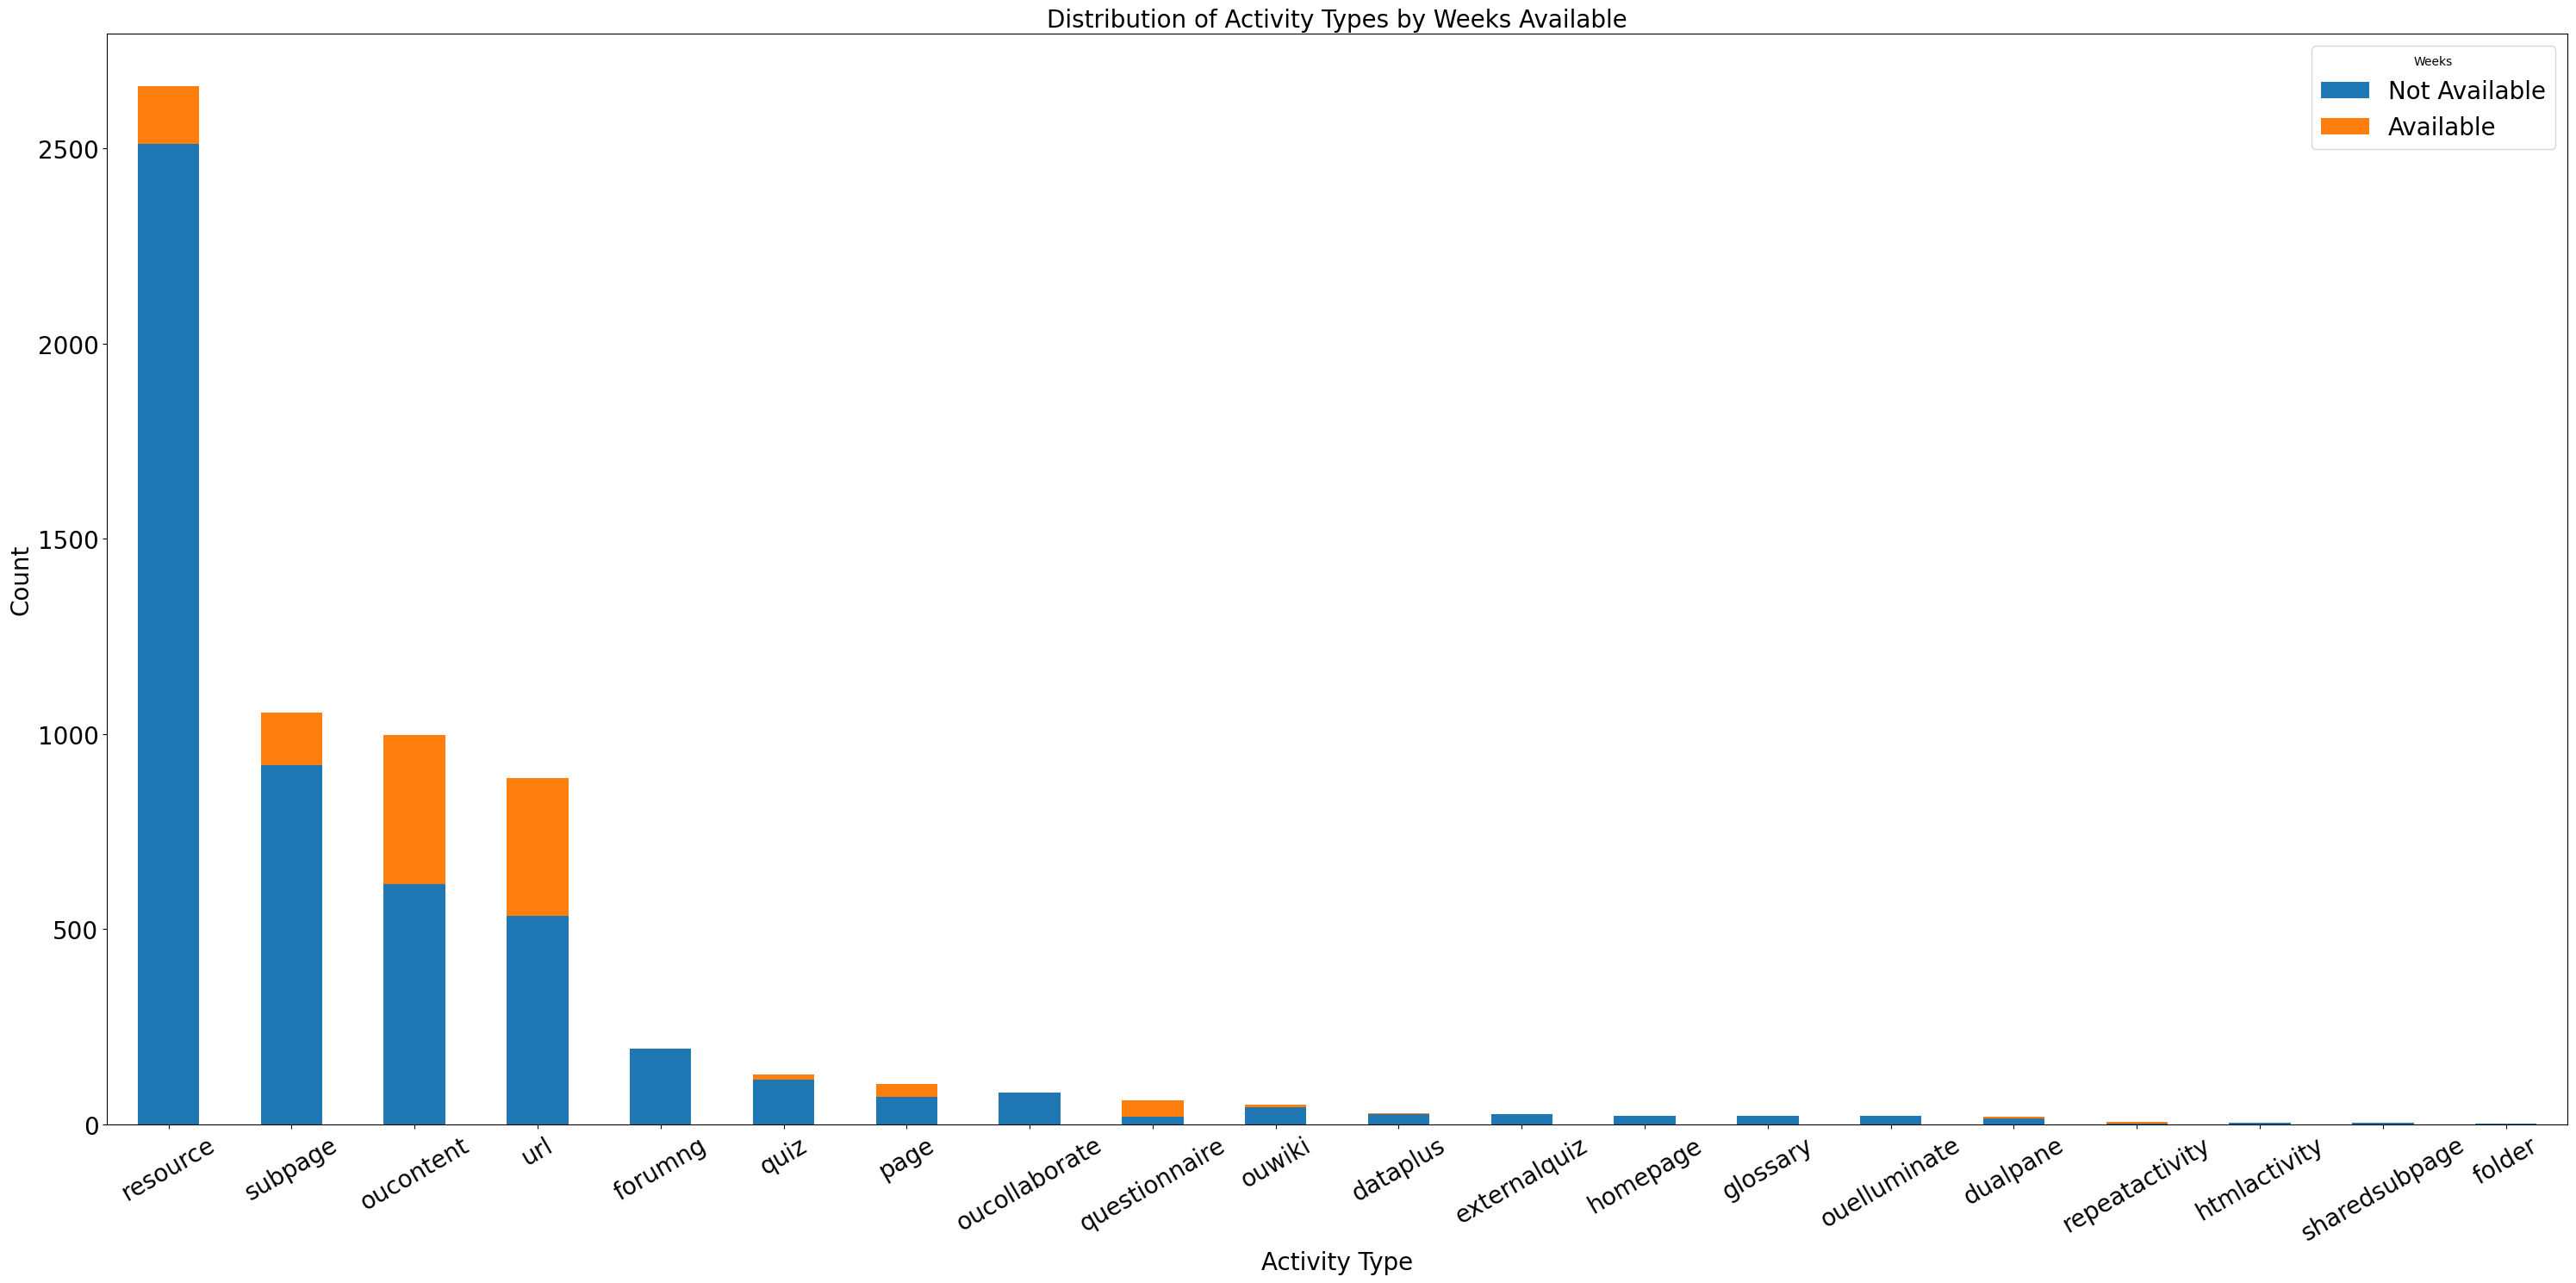

In [46]:
# let's take a look at the activity_type of vle that have the week_from & week_to available in comparison
df_vle['weeks_available'] = ((df_vle['week_from'].notna())&(df_vle['week_to'].notna()))

activity_weeks = pd.crosstab(df_vle['activity_type'], df_vle['weeks_available'])

# order based on bar size
activity_weeks['total'] = activity_weeks.sum(axis=1)
activity_weeks_sorted = activity_weeks.sort_values(by='total', ascending=False)
activity_weeks_sorted = activity_weeks_sorted.drop(columns='total')

fontsize=20

activity_weeks_sorted.plot(kind='bar', stacked=True, figsize=(30, 15), fontsize=fontsize, rot=30)

plt.title('Distribution of Activity Types by Weeks Available', fontsize=fontsize)
plt.xlabel('Activity Type', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.legend(title='Weeks', labels=['Not Available', 'Available'], fontsize=fontsize)
plt.tight_layout()
plt.show()

-> oucontent and url are vle where the weeks in which to use them is given the most

## studentInfo

code_module – an identification code for a module on which the student is registered.

code_presentation - the identification code of the presentation during which the student is registered on the module.

id_student – a unique identification number for the student.

gender – the student’s gender.

region – identifies the geographic region, where the student lived while taking the module-presentation.

highest_education – highest student education level on entry to the module presentation.

imd_band – specifies the Index of Multiple Depravation band of the place where the student lived during the module-presentation.

age_band – band of the student’s age.

num_of_prev_attempts – the number times the student has attempted this module.

studied_credits – the total number of credits for the modules the student is currently studying.

disability – indicates whether the student has declared a disability.

final_result – student’s final result in the module-presentation.

In [47]:
df_studentinfo = dfs['studentInfo'].copy()
df_studentinfo

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail
32589,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction
32590,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass
32591,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn


In [48]:
# check for duplicates
df_studentinfo.duplicated().sum()

0

In [49]:
# check column types
df_studentinfo.dtypes

code_module             object
code_presentation       object
id_student               int64
gender                  object
region                  object
highest_education       object
imd_band                object
age_band                object
num_of_prev_attempts     int64
studied_credits          int64
disability              object
final_result            object
dtype: object

In [50]:
df_studentinfo.isna().sum()

code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
dtype: int64

In [51]:
df_studentinfo.describe()

,id_student,num_of_prev_attempts,studied_credits
count,3.259300e+04,32593.000000,32593.000000
mean,7.066877e+05,0.163225,79.758691
std,5.491673e+05,0.479758,41.071900
min,3.733000e+03,0.000000,30.000000
25%,5.085730e+05,0.000000,60.000000
50%,5.903100e+05,0.000000,60.000000
75%,6.444530e+05,0.000000,120.000000
max,2.716795e+06,6.000000,655.000000


In [52]:
df_studentinfo['id_student'].nunique()

28785

-> multiple lines for one id_student in this table

Text(0, 0.5, 'Number of course participations')

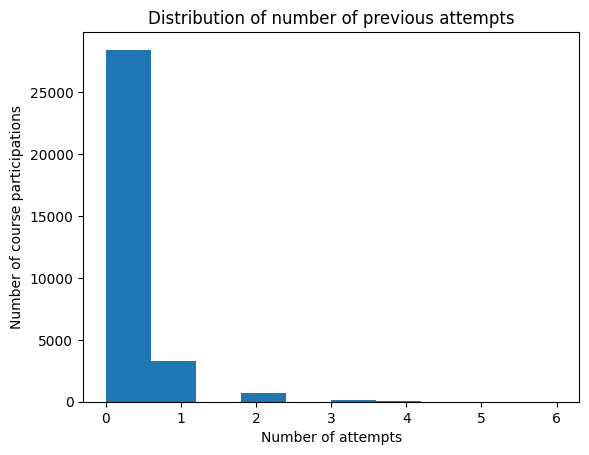

In [53]:
plt.hist(df_studentinfo['num_of_prev_attempts'], bins=None)
plt.title('Distribution of number of previous attempts')
plt.xlabel('Number of attempts')
plt.ylabel('Number of course participations')

Text(0, 0.5, 'Number of course participations')

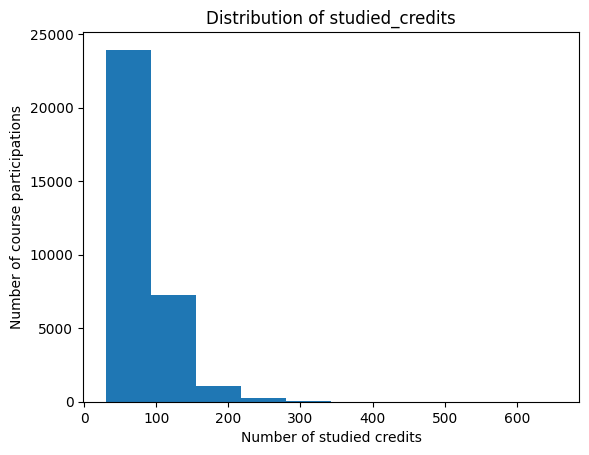

In [54]:
plt.hist(df_studentinfo['studied_credits'], bins=None)
plt.title('Distribution of studied_credits')
plt.xlabel('Number of studied credits')
plt.ylabel('Number of course participations')

In [55]:
df_studentinfo.describe(include='object')

,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,disability,final_result
count,32593,32593,32593,32593,32593,31482,32593,32593,32593
unique,7,4,2,13,5,10,3,2,4
top,BBB,2014J,M,Scotland,A Level or Equivalent,20-30%,0-35,N,Pass
freq,7909,11260,17875,3446,14045,3654,22944,29429,12361


C:\Users\YoeriA\AppData\Local\Temp\ipykernel_5652\2561710387.py:18: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



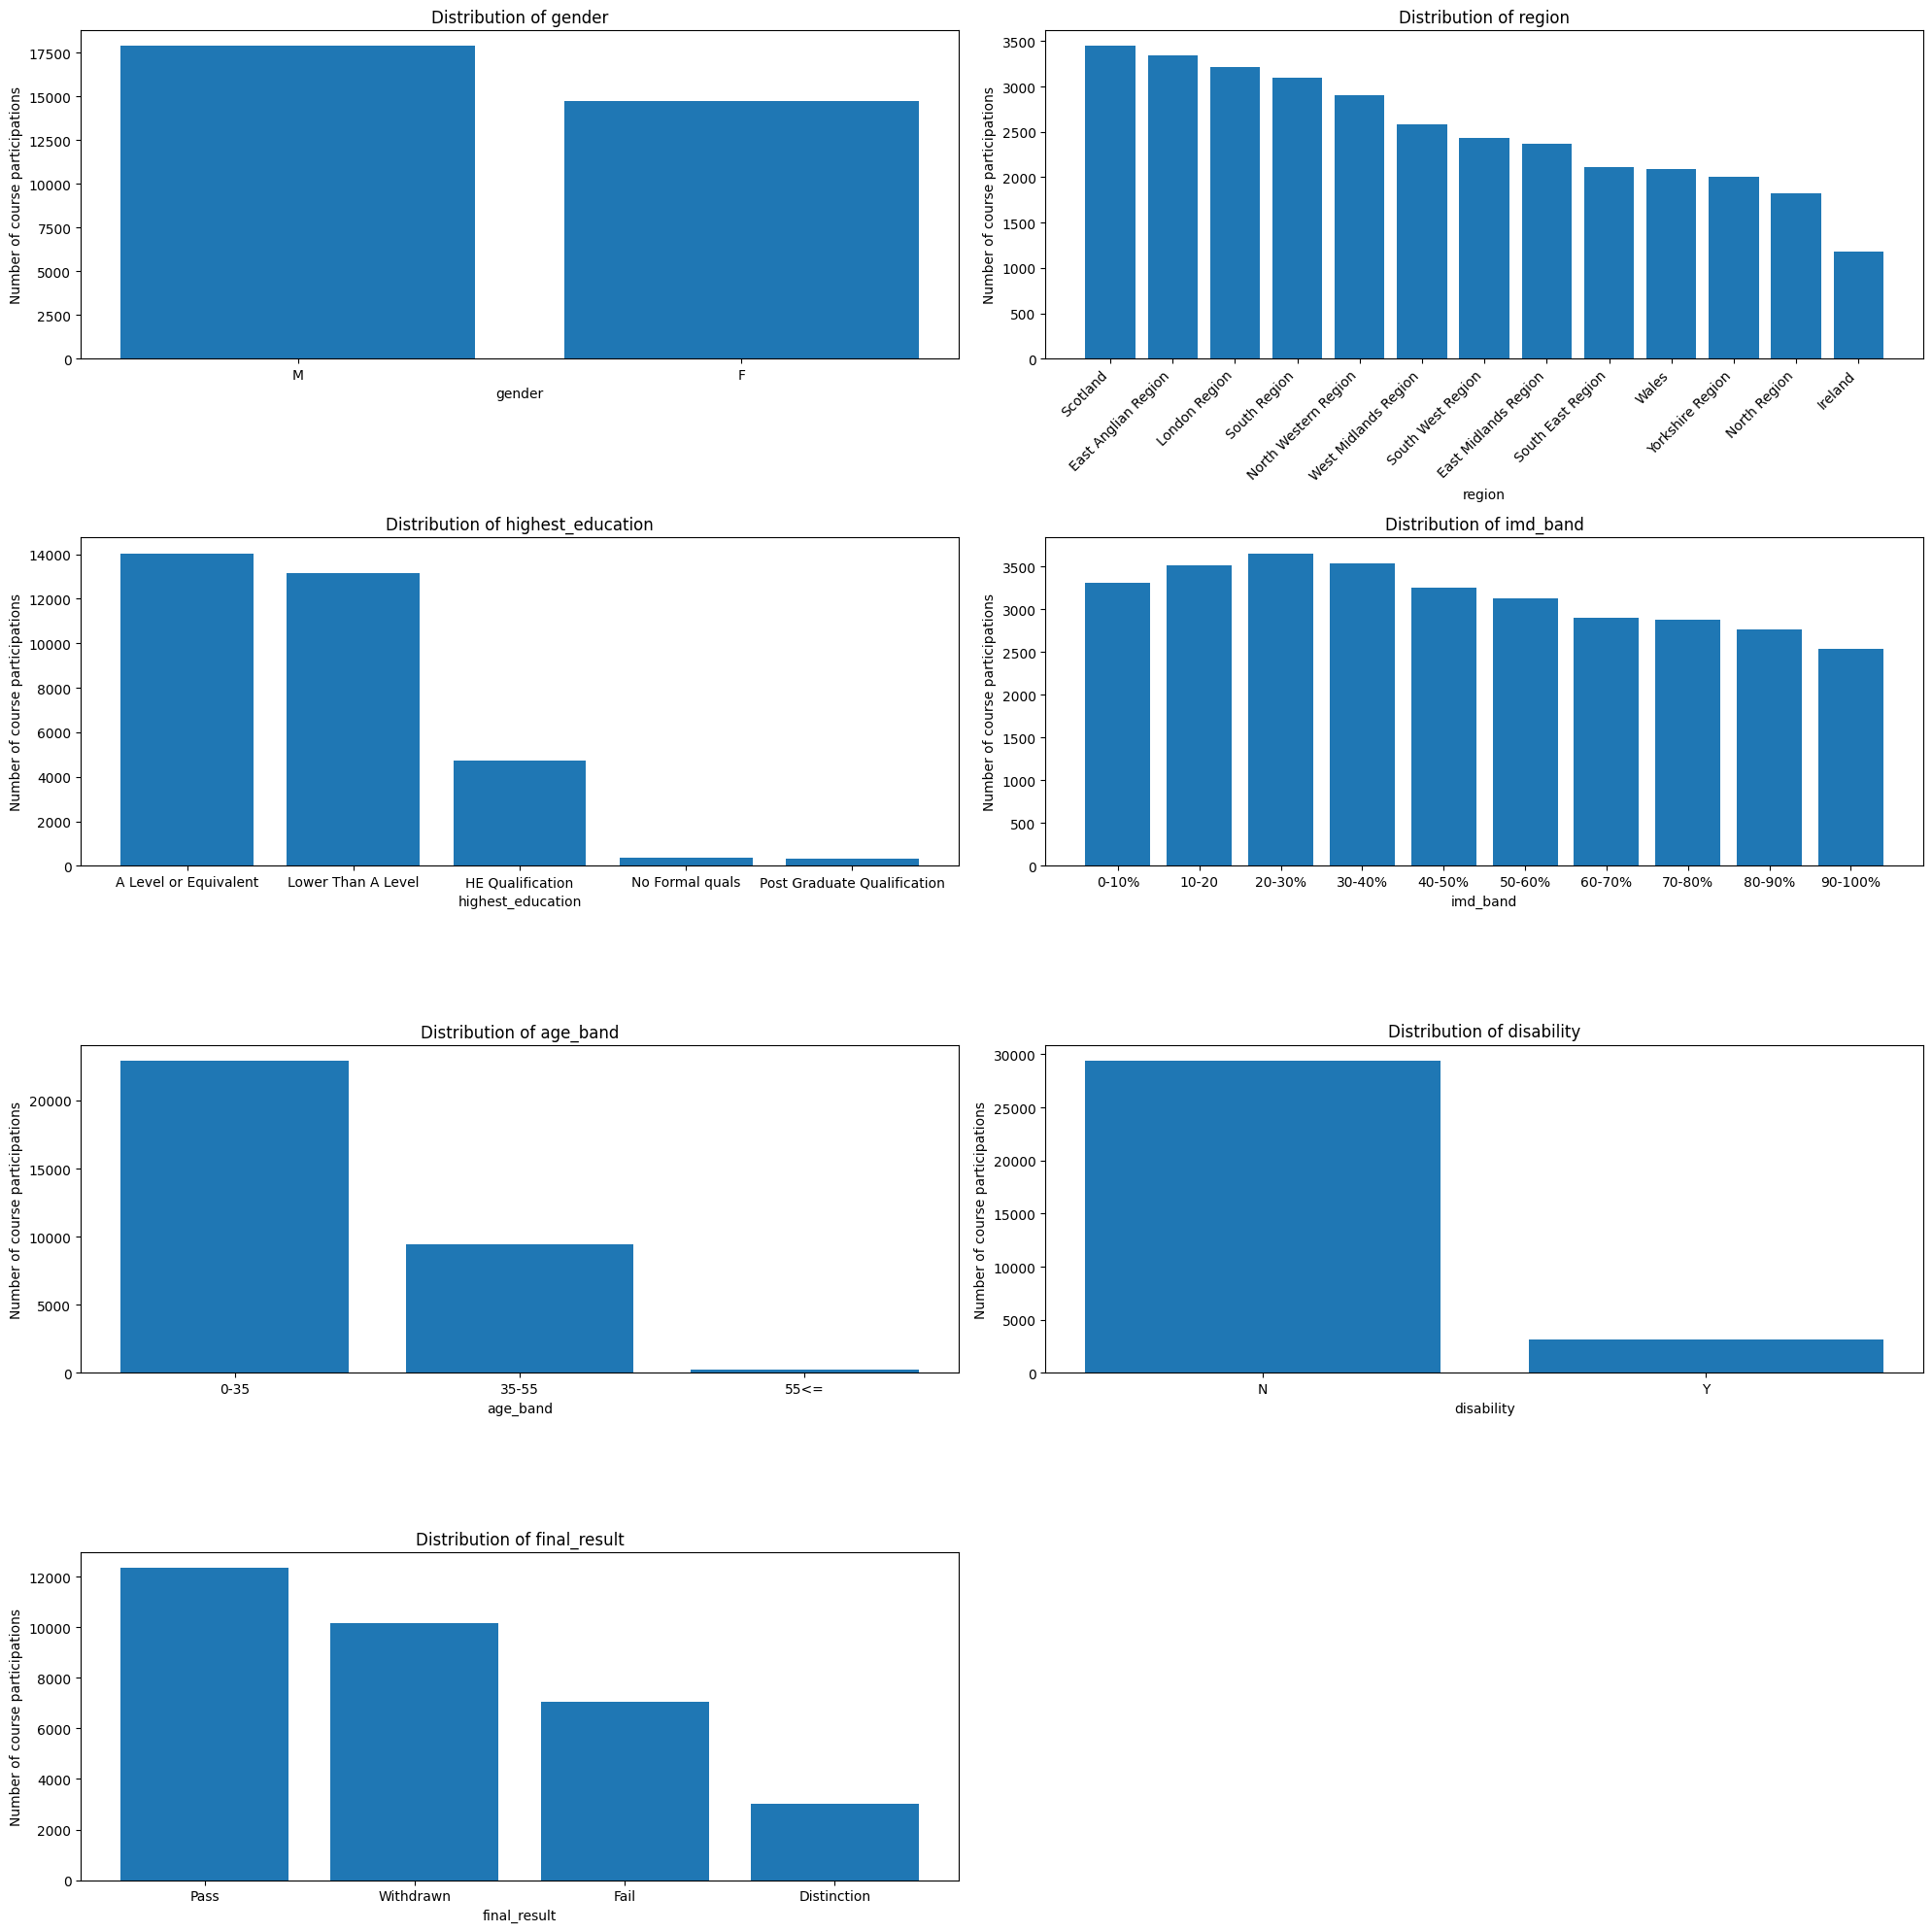

In [56]:
cat_variables = ['gender', 'region', 'highest_education', 'imd_band', 'age_band', 'disability', 'final_result']
fig, axes = plt.subplots(4, 2, figsize=(20, 20))
axes = axes.flatten()


for i, variable in enumerate(cat_variables):
    # sort bands on x axis
    if variable in ['imd_band', 'age_band']:
        data = df_studentinfo[f'{variable}'].value_counts().sort_index()
    else:
        data = df_studentinfo[f'{variable}'].value_counts()
    ax = axes[i]

    ax.bar(data.index, data)
    ax.set_title(f'Distribution of {variable}')
    ax.set_xlabel(f'{variable}')
    if variable == 'region':
        ax.set_xticklabels(data.index, rotation=45, ha='right')
    ax.set_ylabel('Number of course participations')
    

fig.delaxes(axes[-1])
plt.tight_layout()



## studentRegistration

code_module – an identification code for a module.

code_presentation - the identification code of the presentation.

id_student – a unique identification number for the student.

date_registration – the date of student’s registration on the module presentation, this is the number of days measured relative to the start of the module-presentation (e.g. the negative value -30 means that the student registered to module presentation 30 days before it started).

date_unregistration – date of student unregistration from the module presentation, this is the number of days measured relative to the start of the module-presentation. Students, who completed the course have this field empty. Students who unregistered have Withdrawal as the value of the final_result column in the studentInfo.csv file.

In [57]:
df_studentregistration = dfs['studentRegistration']
df_studentregistration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


In [58]:
# check for duplicates
df_studentregistration.duplicated().sum()

0

In [59]:
# check column types
df_studentregistration.dtypes

code_module             object
code_presentation       object
id_student               int64
date_registration      float64
date_unregistration    float64
dtype: object

In [60]:
df_studentregistration.isna().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64

In [61]:
df_studentregistration.describe()

,id_student,date_registration,date_unregistration
count,3.259300e+04,32548.000000,10072.000000
mean,7.066877e+05,-69.411300,49.757645
std,5.491673e+05,49.260522,82.460890
min,3.733000e+03,-322.000000,-365.000000
25%,5.085730e+05,-100.000000,-2.000000
50%,5.903100e+05,-57.000000,27.000000
75%,6.444530e+05,-29.000000,109.000000
max,2.716795e+06,167.000000,444.000000


In [62]:
# check whether there are unregistrations without registration dates
df_studentregistration[df_studentregistration['date_unregistration'].notna() & df_studentregistration['date_registration'].isna()]


,code_module,code_presentation,id_student,date_registration,date_unregistration
2538,BBB,2013J,57369,NaN,-1.0
2759,BBB,2013J,342678,NaN,-33.0
5356,BBB,2014B,582496,NaN,-126.0
5490,BBB,2014B,607646,NaN,-38.0
5573,BBB,2014B,614270,NaN,-142.0
6295,BBB,2014B,2409808,NaN,-109.0
6305,BBB,2014B,2439442,NaN,-149.0
8307,BBB,2014J,694001,NaN,-36.0
8975,CCC,2014B,394791,NaN,-61.0
9523,CCC,2014B,575419,NaN,-24.0


In [63]:
# this table only gives extra information about two variables. We'll add them to the studentinfo table
df_studentinfo = df_studentinfo.merge(df_studentregistration[['code_module', 'code_presentation', 'id_student', 'date_registration', 'date_unregistration']],
                                      on=['code_module', 'code_presentation', 'id_student'],
                                      how='left')

df_studentinfo

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,NaN
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,NaN
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92.0,12.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52.0,NaN
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail,-4.0,NaN
32589,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction,-23.0,NaN
32590,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass,-129.0,NaN
32591,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn,-49.0,101.0


In [64]:
# check if unregistration has the correct result (withdrawn)
df_studentinfo[df_studentinfo['date_unregistration'].notna()].final_result.value_counts()

final_result
Withdrawn    10063
Fail             9
Name: count, dtype: int64

In [65]:
# Let's look at the 'Fail' attempts of people who unregistered
df_studentinfo[(df_studentinfo['date_unregistration'].notna())&(df_studentinfo['final_result']=='Fail')]


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration
2777,BBB,2013J,362907,F,South West Region,Lower Than A Level,20-30%,35-55,2,60,N,Fail,-37.0,0.0
2786,BBB,2013J,365288,F,South Region,A Level or Equivalent,70-80%,0-35,0,60,N,Fail,-75.0,0.0
3340,BBB,2013J,554243,F,South West Region,Lower Than A Level,60-70%,0-35,0,60,N,Fail,-35.0,166.0
14625,DDD,2013J,315082,M,West Midlands Region,A Level or Equivalent,50-60%,0-35,0,60,N,Fail,-73.0,0.0
14768,DDD,2013J,403052,F,Yorkshire Region,HE Qualification,20-30%,0-35,0,150,N,Fail,-22.0,0.0
15577,DDD,2013J,582954,M,London Region,Lower Than A Level,10-20,0-35,0,120,N,Fail,-81.0,-7.0
24057,FFF,2013J,234004,M,Yorkshire Region,A Level or Equivalent,50-60%,0-35,0,60,N,Fail,-33.0,0.0
24537,FFF,2013J,523777,M,North Region,A Level or Equivalent,0-10%,35-55,1,60,N,Fail,-60.0,0.0
25685,FFF,2013J,601640,M,London Region,HE Qualification,20-30%,0-35,0,90,N,Fail,-58.0,-4.0


Text(0, 0.5, 'Registration Duration (days)')

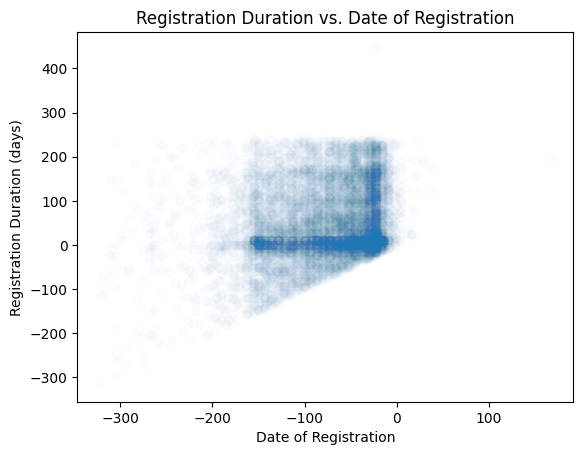

In [66]:
# Look at relationship between date of registration and unregistration
plt.scatter(df_studentinfo['date_registration'], df_studentinfo['date_unregistration'], alpha=0.01)
plt.title('Registration Duration vs. Date of Registration')
plt.xlabel('Date of Registration')
plt.ylabel('Registration Duration (days)')

-> a lot of activity on start date (day 0)

In [67]:
# check period between registration and unregistration
df_studentinfo['registration_duration'] = (df_studentinfo['date_unregistration']-df_studentinfo['date_registration'])
df_studentinfo['registration_duration'].describe()

count    10033.000000
mean       128.797568
std         85.694853
min          0.000000
25%         57.000000
50%        117.000000
75%        186.000000
max        531.000000
Name: registration_duration, dtype: float64

## studentAssessment

id_assessment – the identification number of the assessment.

id_student – a unique identification number for the student.

date_submitted – the date of student submission, measured as the number of days since the start of the module presentation.

is_banked – a status flag indicating that the assessment result has been transferred from a previous presentation.

score – the student’s score in this assessment. The range is from 0 to 100. The score lower than 40 is interpreted as Fail. The marks are in the range from 0 to 100.

In [68]:
df_studentassessment = dfs['studentAssessment']
df_studentassessment.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [69]:
# check for duplicates
df_studentassessment.duplicated().sum()

0

In [70]:
# check column types
df_studentassessment.dtypes

id_assessment       int64
id_student          int64
date_submitted      int64
is_banked           int64
score             float64
dtype: object

In [71]:
df_studentassessment.isna().sum()

id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

In [72]:
df_studentassessment[df_studentassessment.score.isna()]

,id_assessment,id_student,date_submitted,is_banked,score
215,1752,721259,22,0,NaN
937,1754,260355,127,0,NaN
2364,1760,2606802,180,0,NaN
3358,14984,186780,77,0,NaN
3914,14984,531205,26,0,NaN
...,...,...,...,...,...
148929,34903,582670,241,0,NaN
159251,37415,610738,87,0,NaN
166390,37427,631786,221,0,NaN
169725,37435,648110,62,0,NaN


In [73]:
# check whether missings are found in a few assessments only
df_studentassessment[df_studentassessment.score.isna()].id_assessment.value_counts()


id_assessment
25339    7
15013    7
34860    6
14998    5
25363    5
        ..
30710    1
30714    1
30715    1
30719    1
25355    1
Name: count, Length: 78, dtype: int64

-> missings in many different assessments

In [74]:
df_assessments.columns

Index(['code_module', 'code_presentation', 'id_assessment', 'assessment_type',
       'date', 'weight', 'weight_norm', 'module_presentation_length', 'year',
       'start_month', 'date_norm'],
      dtype='object')

In [75]:
# check why some scores are missing
id = 25339

# check due date of assignment
df_assessments[df_assessments.id_assessment==id].date

86    200.0
Name: date, dtype: float64

In [76]:
# check when assignments were submitted for rows without score
df_studentassessment[(df_studentassessment.id_assessment==id)&(df_studentassessment.score.isna())]

,id_assessment,id_student,date_submitted,is_banked,score
69153,25339,560260,201,0,NaN
69277,25339,191896,221,0,NaN
69285,25339,241771,203,0,NaN
69292,25339,252489,213,0,NaN
69365,25339,412731,211,0,NaN
69367,25339,413934,221,0,NaN
69371,25339,415695,214,0,NaN


-> all NaN scores where submitted late for this assessment

In [77]:
df_studentassessment.describe()

,id_assessment,id_student,date_submitted,is_banked,score
count,173912.000000,1.739120e+05,173912.000000,173912.000000,173739.000000
mean,26553.803556,7.051507e+05,116.032942,0.010977,75.799573
std,8829.784254,5.523952e+05,71.484148,0.104194,18.798107
min,1752.000000,6.516000e+03,-11.000000,0.000000,0.000000
25%,15022.000000,5.044290e+05,51.000000,0.000000,65.000000
50%,25359.000000,5.852080e+05,116.000000,0.000000,80.000000
75%,34883.000000,6.344980e+05,173.000000,0.000000,90.000000
max,37443.000000,2.698588e+06,608.000000,1.000000,100.000000


Text(0, 0.5, 'Number of course participations')

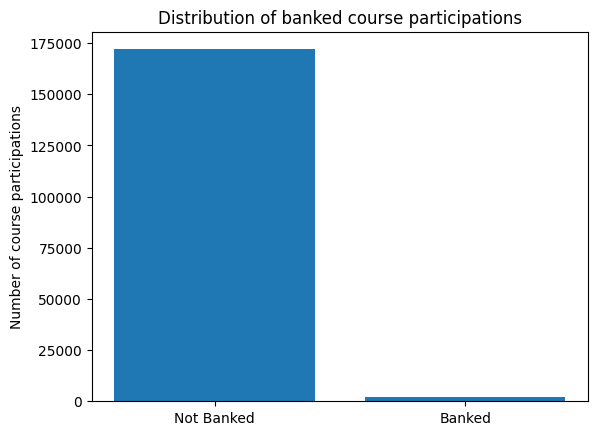

In [78]:
data = df_studentassessment['is_banked'].astype(bool).value_counts()
plt.bar(data.index.map({True: 'Banked', False: 'Not Banked'}), data)
plt.title('Distribution of banked course participations')
plt.ylabel('Number of course participations')

Text(0, 0.5, 'Number of course participations')

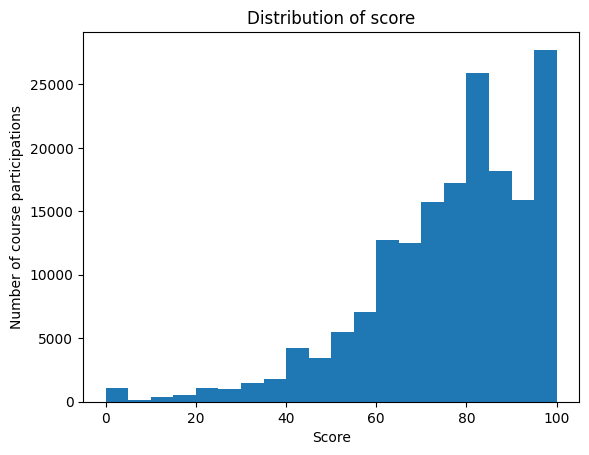

In [79]:
plt.hist(df_studentassessment['score'], bins=20)
plt.title('Distribution of score')
plt.xlabel('Score')
plt.ylabel('Number of course participations')

In [80]:
# let's look at the score distribution per assessment_type

# add details course + date(_norm) &  assessment to df_studentassessment
df_studentassessment = df_studentassessment.merge(df_assessments[['code_module', 'code_presentation','id_assessment', 'date', 'assessment_type']],
                                      on='id_assessment',
                                      how='left')

df_studentassessment

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,date,assessment_type
0,1752,11391,18,0,78.0,AAA,2013J,19.0,TMA
1,1752,28400,22,0,70.0,AAA,2013J,19.0,TMA
2,1752,31604,17,0,72.0,AAA,2013J,19.0,TMA
3,1752,32885,26,0,69.0,AAA,2013J,19.0,TMA
4,1752,38053,19,0,79.0,AAA,2013J,19.0,TMA
...,...,...,...,...,...,...,...,...,...
173907,37443,527538,227,0,60.0,GGG,2014J,229.0,CMA
173908,37443,534672,229,0,100.0,GGG,2014J,229.0,CMA
173909,37443,546286,215,0,80.0,GGG,2014J,229.0,CMA
173910,37443,546724,230,0,100.0,GGG,2014J,229.0,CMA


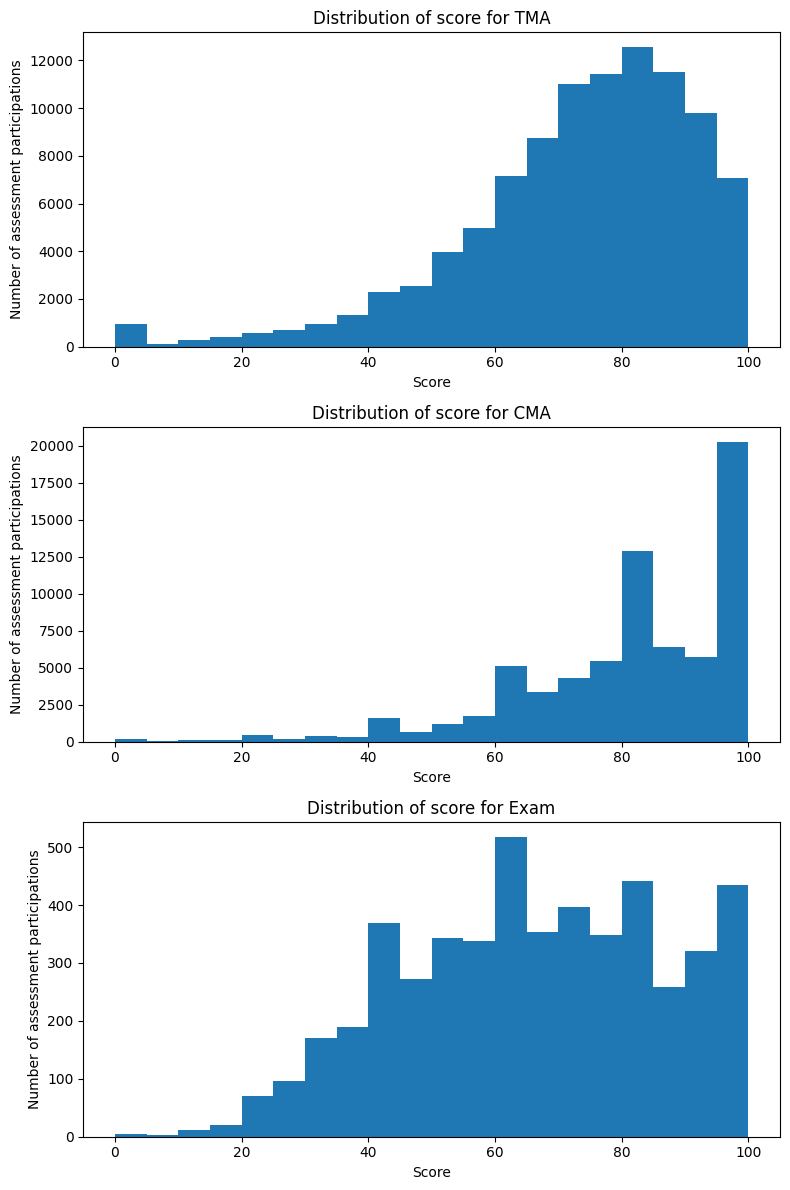

In [81]:
# create score distribution plot per assessment_type
unique_assessment_types = df_studentassessment['assessment_type'].unique()

fig, axes = plt.subplots(len(unique_assessment_types), 1, figsize=(8, 4 * len(unique_assessment_types)))

for i, assessment_type in enumerate(unique_assessment_types):
    data = df_studentassessment[df_studentassessment['assessment_type'] == assessment_type]['score']

    axes[i].hist(data, bins=20)
    axes[i].set_title(f'Distribution of score for {assessment_type}')
    axes[i].set_xlabel('Score')
    axes[i].set_ylabel('Number of assessment participations')

plt.tight_layout()

In [82]:
# no categorical variables
df_studentassessment.describe(include='object')


,code_module,code_presentation,assessment_type
count,173912,173912,173912
unique,7,4,3
top,FFF,2014J,TMA
freq,54815,52174,98426


Text(0, 0.5, 'Number of assessment participations')

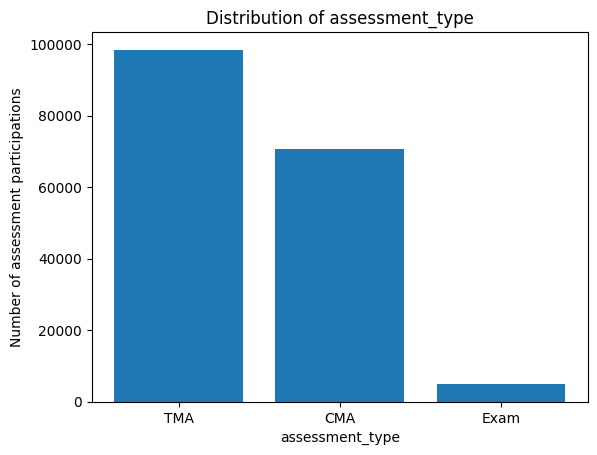

In [83]:
# look at assessment_type distribution of all assessment participations
data = df_studentassessment['assessment_type'].value_counts()

plt.bar(data.index, data)
plt.title(f'Distribution of assessment_type')
plt.xlabel('assessment_type')
plt.ylabel('Number of assessment participations')

In [84]:
# calculate date relative to assigment date
df_studentassessment['date_submitted_relative'] = df_studentassessment['date_submitted'] - df_studentassessment['date']
df_studentassessment

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,date,assessment_type,date_submitted_relative
0,1752,11391,18,0,78.0,AAA,2013J,19.0,TMA,-1.0
1,1752,28400,22,0,70.0,AAA,2013J,19.0,TMA,3.0
2,1752,31604,17,0,72.0,AAA,2013J,19.0,TMA,-2.0
3,1752,32885,26,0,69.0,AAA,2013J,19.0,TMA,7.0
4,1752,38053,19,0,79.0,AAA,2013J,19.0,TMA,0.0
...,...,...,...,...,...,...,...,...,...,...
173907,37443,527538,227,0,60.0,GGG,2014J,229.0,CMA,-2.0
173908,37443,534672,229,0,100.0,GGG,2014J,229.0,CMA,0.0
173909,37443,546286,215,0,80.0,GGG,2014J,229.0,CMA,-14.0
173910,37443,546724,230,0,100.0,GGG,2014J,229.0,CMA,1.0


In [85]:
df_studentassessment['date_submitted_relative'].value_counts() # -> correct with line in chart belowN
# fix x axis -> peak should be 0

date_submitted_relative
 0.0      29469
-1.0      25846
 2.0      19318
-2.0      10455
 3.0       7827
          ...  
 334.0        1
 148.0        1
 230.0        1
 309.0        1
 83.0         1
Name: count, Length: 390, dtype: int64

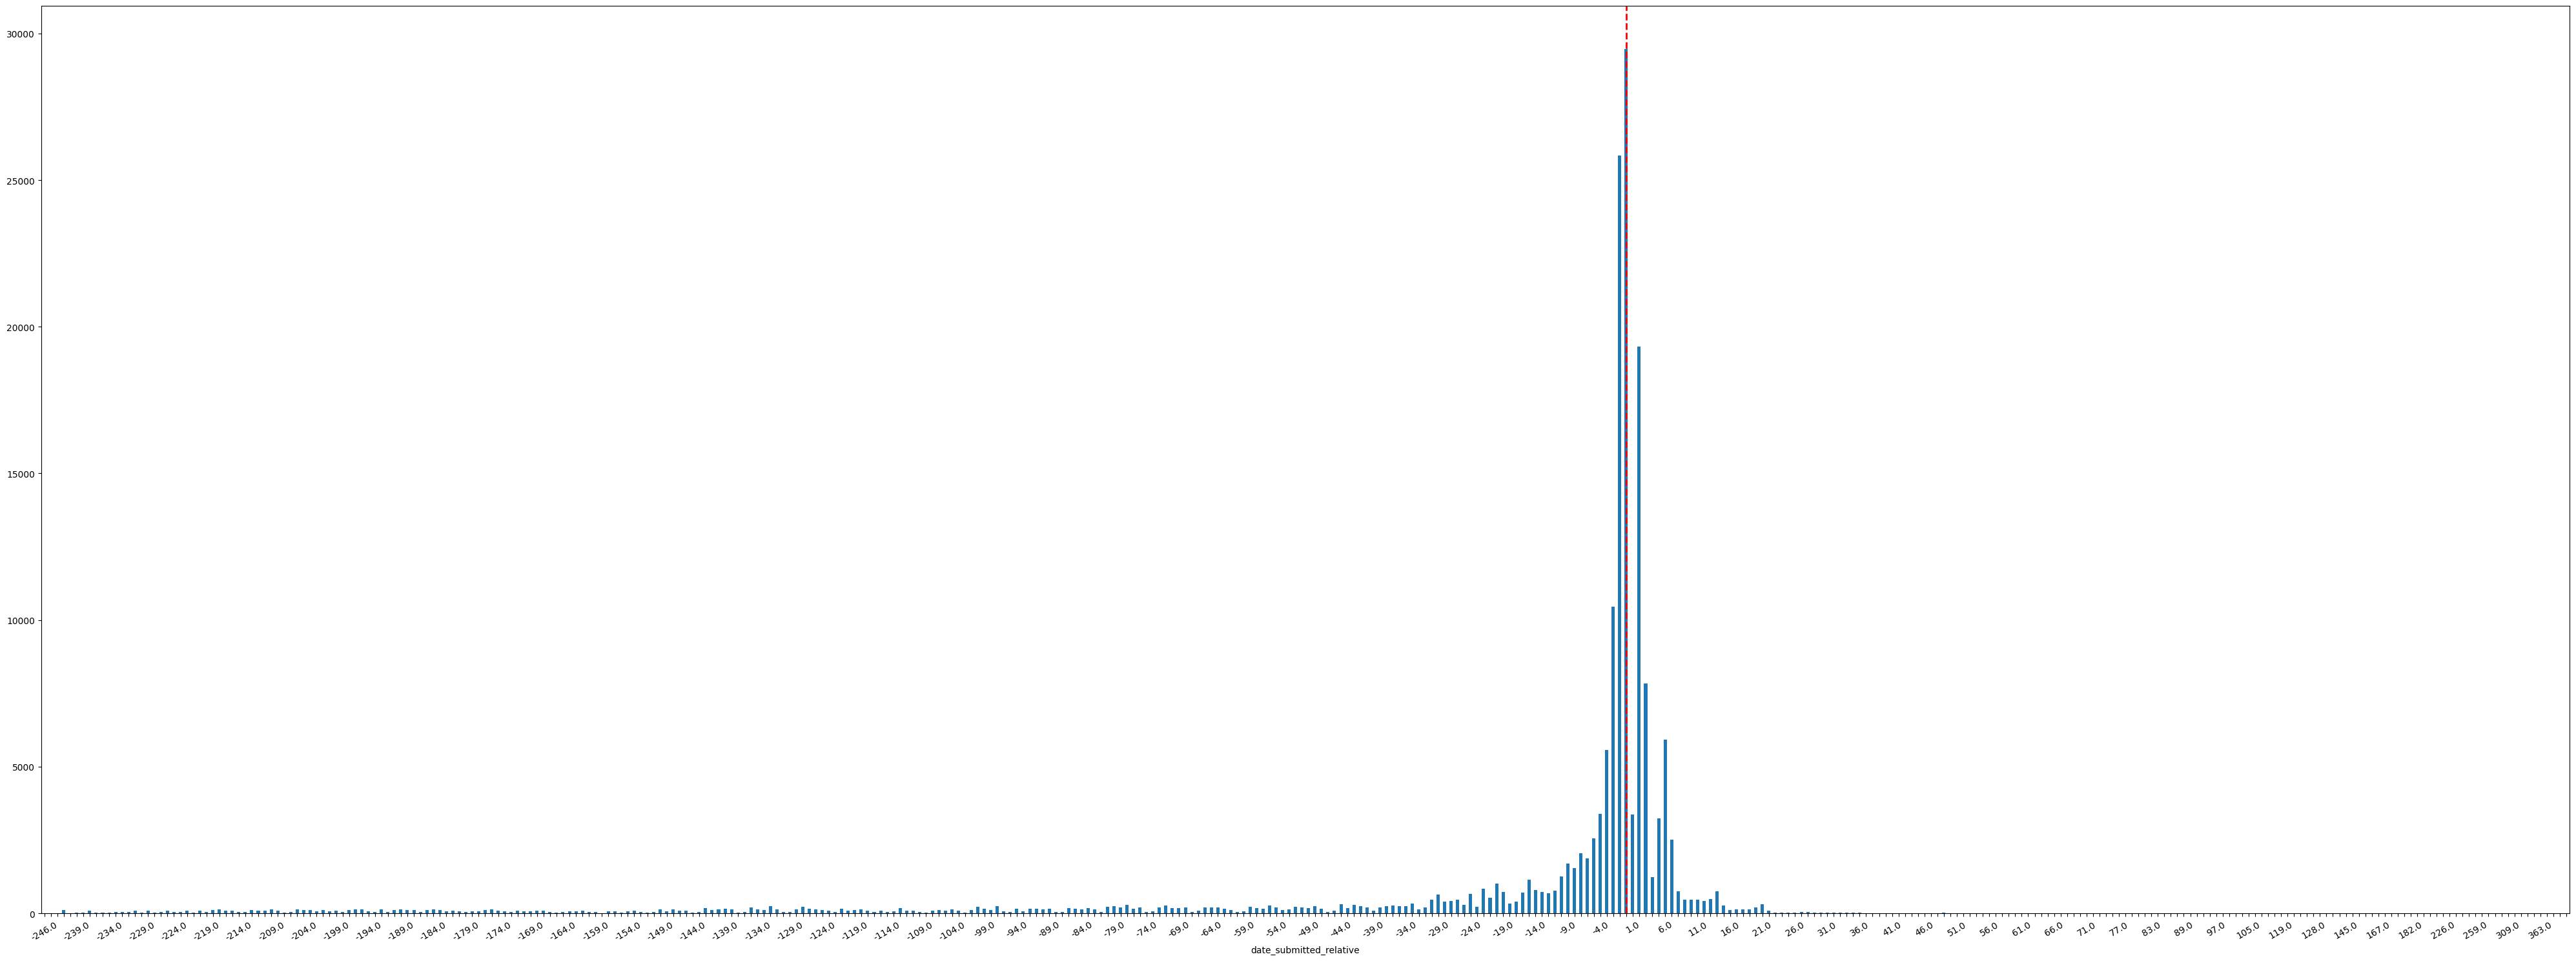

In [86]:
# create chart for date_submitted_relative
data = df_studentassessment['date_submitted_relative'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(40, 15))
data.plot(kind='bar', ax=ax, fontsize=10, rot=30)

# Find the index of the '0' value in the sorted data
zero_index = data.index.get_loc(0) if 0 in data.index else None

# Add vertical line at deadline position (date_submitted_relative=0)
if zero_index is not None:
    ax.axvline(x=zero_index, color='red', linestyle='--', linewidth=2)

# Reduce the number of x-axis ticks
n = 5  # Show every nth label, adjust n as needed
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % n != 0:
        label.set_visible(False)
        
plt.tight_layout()


## studentVle

code_module – an identification code for a module.

code_presentation - the identification code of the module presentation.

id_student – a unique identification number for the student.

id_site - an identification number for the VLE material.

date – the date of student’s interaction with the material measured as the number of days since the start of the module-presentation.

sum_click – the number of times a student interacts with the material in that day

In [87]:
df_studentvle = dfs['studentVle'].copy()
df_studentvle

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1
...,...,...,...,...,...,...
10655275,GGG,2014J,675811,896943,269,3
10655276,GGG,2014J,675578,896943,269,1
10655277,GGG,2014J,654064,896943,269,3
10655278,GGG,2014J,654064,896939,269,1


In [88]:
# check for duplicates
df_studentvle.duplicated().sum()

787170

-> it makes sense that the same student clicked on the same resource a same number of times in the same day ; unclear how sum_click is calculated

In [89]:
# check column types
df_studentvle.dtypes

code_module          object
code_presentation    object
id_student            int64
id_site               int64
date                  int64
sum_click             int64
dtype: object

In [90]:
df_studentvle.isna().sum()

code_module          0
code_presentation    0
id_student           0
id_site              0
date                 0
sum_click            0
dtype: int64

In [91]:
df_studentvle.describe()

,id_student,id_site,date,sum_click
count,1.065528e+07,1.065528e+07,1.065528e+07,1.065528e+07
mean,7.333336e+05,7.383234e+05,9.517400e+01,3.716946e+00
std,5.827060e+05,1.312196e+05,7.607130e+01,8.849047e+00
min,6.516000e+03,5.267210e+05,-2.500000e+01,1.000000e+00
25%,5.077430e+05,6.735190e+05,2.500000e+01,1.000000e+00
50%,5.882360e+05,7.300690e+05,8.600000e+01,2.000000e+00
75%,6.464840e+05,8.770300e+05,1.560000e+02,3.000000e+00
max,2.698588e+06,1.049562e+06,2.690000e+02,6.977000e+03


Text(0, 0.5, 'Number of interactions')

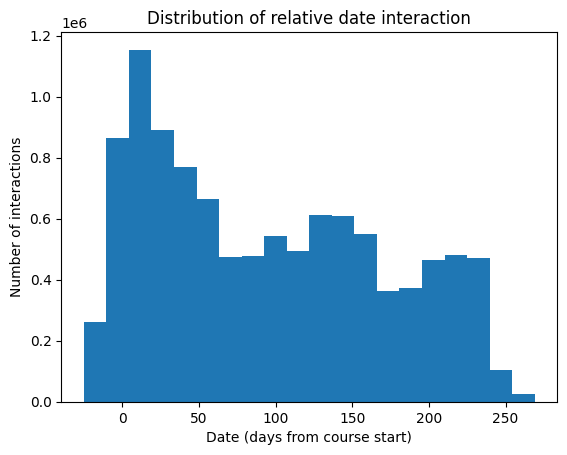

In [92]:
plt.hist(df_studentvle['date'], bins=20)
plt.title('Distribution of relative date interaction')
plt.xlabel('Date (days from course start)')
plt.ylabel('Number of interactions')

-> it seems the distribution is multimodal, possibly related to assessment dates

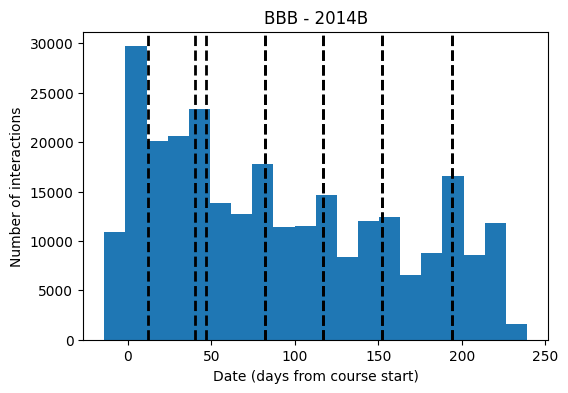

In [93]:
# check for a specific course if interactions are related to assessments

# create chart function 
def chart_assessment_studentinteraction(ax, code_module, code_presentation):
    presentation_assessments = df_assessments[(df_assessments['code_module'] == code_module) & (df_assessments['code_presentation'] == code_presentation)]
    presentation_interactions = df_studentvle[(df_studentvle['code_module'] == code_module) & (df_studentvle['code_presentation'] == code_presentation)]

    x_range = (presentation_interactions['date'].min()-5, presentation_interactions['date'].max()+5)
    ax.hist(presentation_interactions['date'], bins=20, range=x_range)
    ax.set_title(f'{code_module} - {code_presentation}')
    ax.set_xlabel('Date (days from course start)')
    ax.set_ylabel('Number of interactions')

    for date in presentation_assessments.date:
        ax.axvline(x=date, color='black', linestyle='--', linewidth=2)

    
# test function
fig, ax = plt.subplots(figsize=(6, 4))
chart_assessment_studentinteraction(ax, 'BBB', '2014B')

-> increased interaction with vle during assessment dates

Creating plot 1: AAA - 2013J
Creating plot 2: AAA - 2014J
Creating plot 3: BBB - 2013B
Creating plot 4: BBB - 2013J
Creating plot 5: BBB - 2014B
Creating plot 6: BBB - 2014J
Creating plot 7: CCC - 2014B
Creating plot 8: CCC - 2014J
Creating plot 9: DDD - 2013B
Creating plot 10: DDD - 2013J
Creating plot 11: DDD - 2014B
Creating plot 12: DDD - 2014J
Creating plot 13: EEE - 2013J
Creating plot 14: EEE - 2014B
Creating plot 15: EEE - 2014J
Creating plot 16: FFF - 2013B
Creating plot 17: FFF - 2013J
Creating plot 18: FFF - 2014B
Creating plot 19: FFF - 2014J
Creating plot 20: GGG - 2013J
Creating plot 21: GGG - 2014B
Creating plot 22: GGG - 2014J


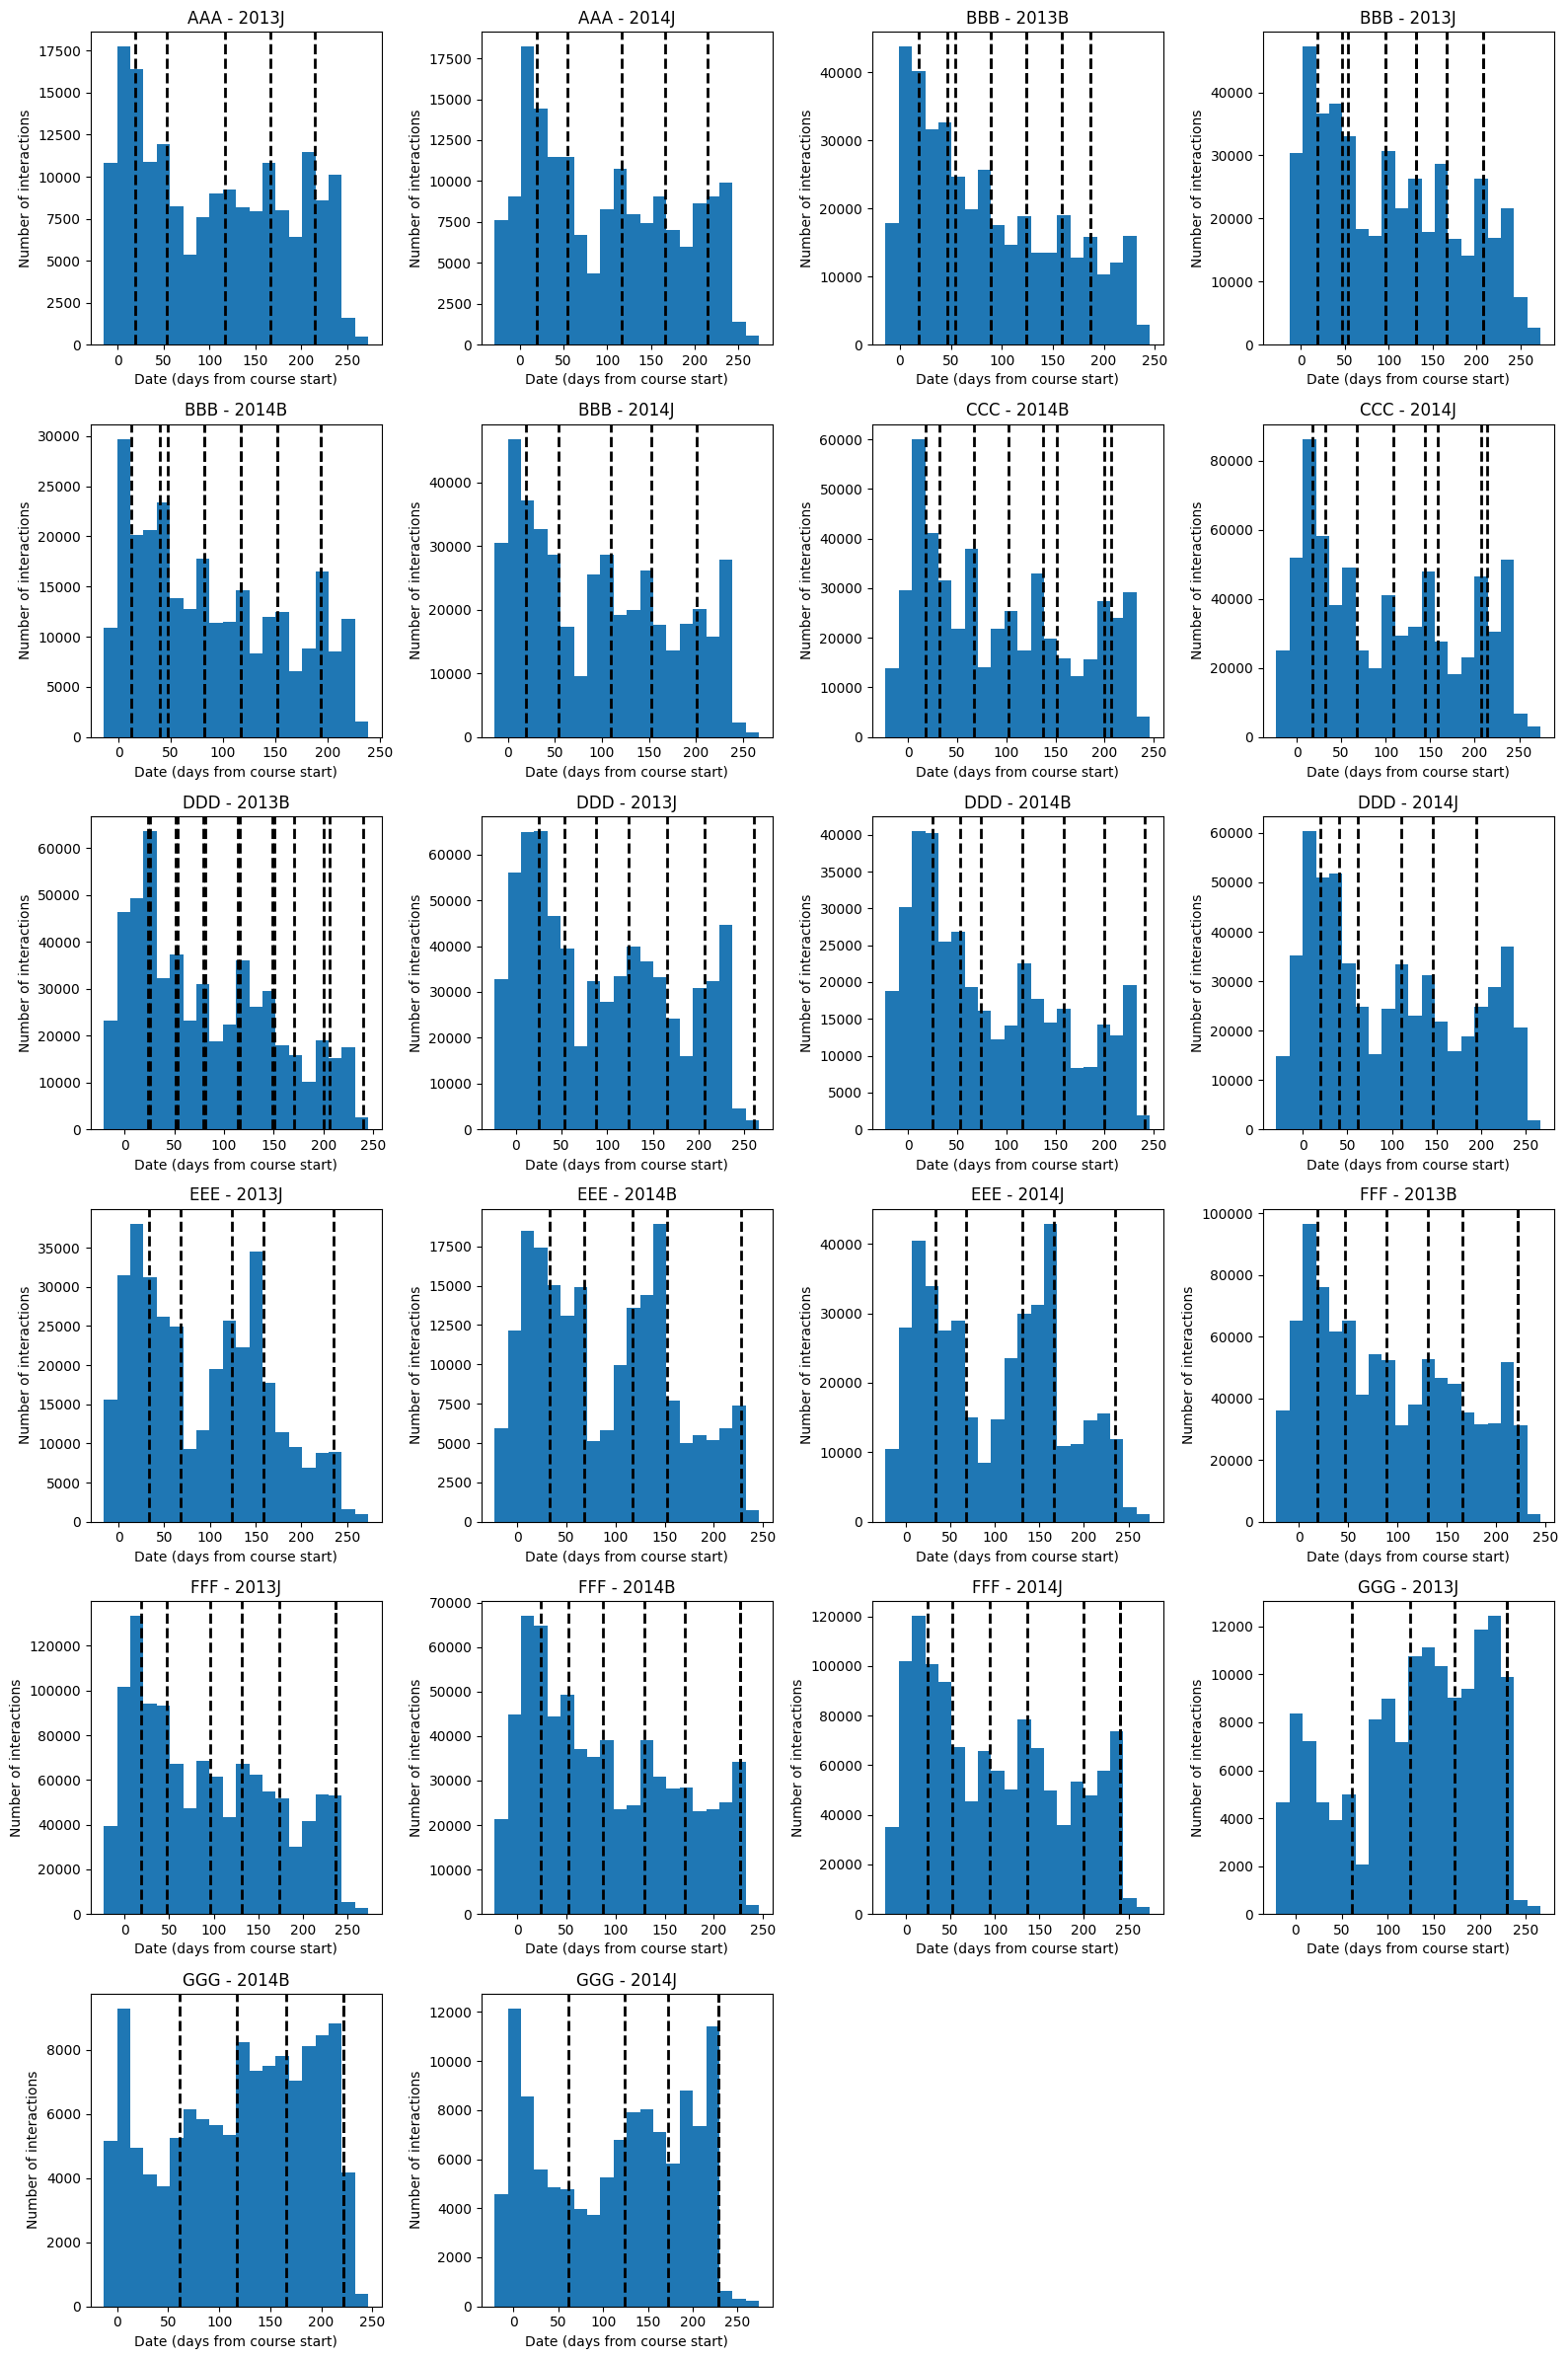

In [94]:
# Check if interactions are related to assessments for all courses

# create list of unique course presentations
unique_course_presentations = df_assessments[['code_module', 'code_presentation']].drop_duplicates().reset_index()
n_plots = len(unique_course_presentations)

# create  subplots
plots_per_row = 4

n_rows = (n_plots//plots_per_row)+1
fig, axes = plt.subplots(n_rows, plots_per_row, figsize=(4*plots_per_row, 4*n_rows))

# delete unnecessary subplots
axes = axes.flatten()
n_surplus = n_plots%plots_per_row

if n_surplus:
    for i in range(n_surplus):
        fig.delaxes(axes[-i-1])

# create chart for each unique course presentation
for i in range(len(unique_course_presentations)):
    code_module = unique_course_presentations.code_module[i]
    code_presentation = unique_course_presentations.code_presentation[i]
    print(f"Creating plot {i+1}: {code_module} - {code_presentation}")
    chart_assessment_studentinteraction(axes[i], code_module, code_presentation)

plt.tight_layout()

-> it seems vle interactions are related to assessment moments 

97.465% of sum_click data used in chart


Text(0, 0.5, 'Number of interactions')

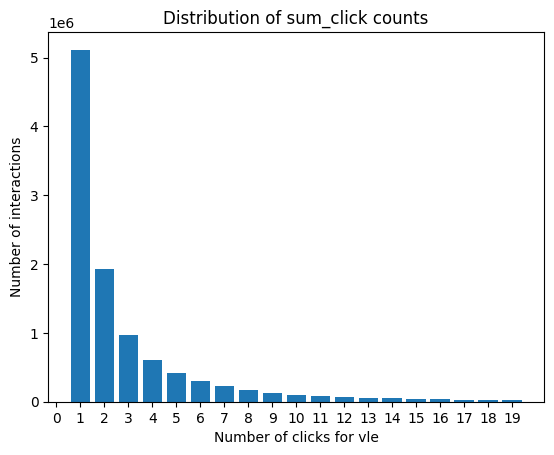

In [95]:
# look at distribution of count of relative interaction date
include_sum_clicks_until_count = 20

data = df_studentvle['sum_click'][df_studentvle['sum_click']<include_sum_clicks_until_count]
percentage_data_used = round((len(data)/len(df_studentvle))*100, 3)
print(f'{percentage_data_used}% of sum_click data used in chart')

value_counts = data.value_counts().sort_index()

plt.bar(value_counts.index, value_counts.values)
plt.xticks(range(include_sum_clicks_until_count))
plt.title('Distribution of sum_click counts')
plt.xlabel('Number of clicks for vle')
plt.ylabel('Number of interactions')

In [96]:
# add the activity_type to df_studentvle
df_studentvle = df_studentvle.merge(df_vle[['id_site','activity_type']],
                    on=['id_site'],
                    how='left')


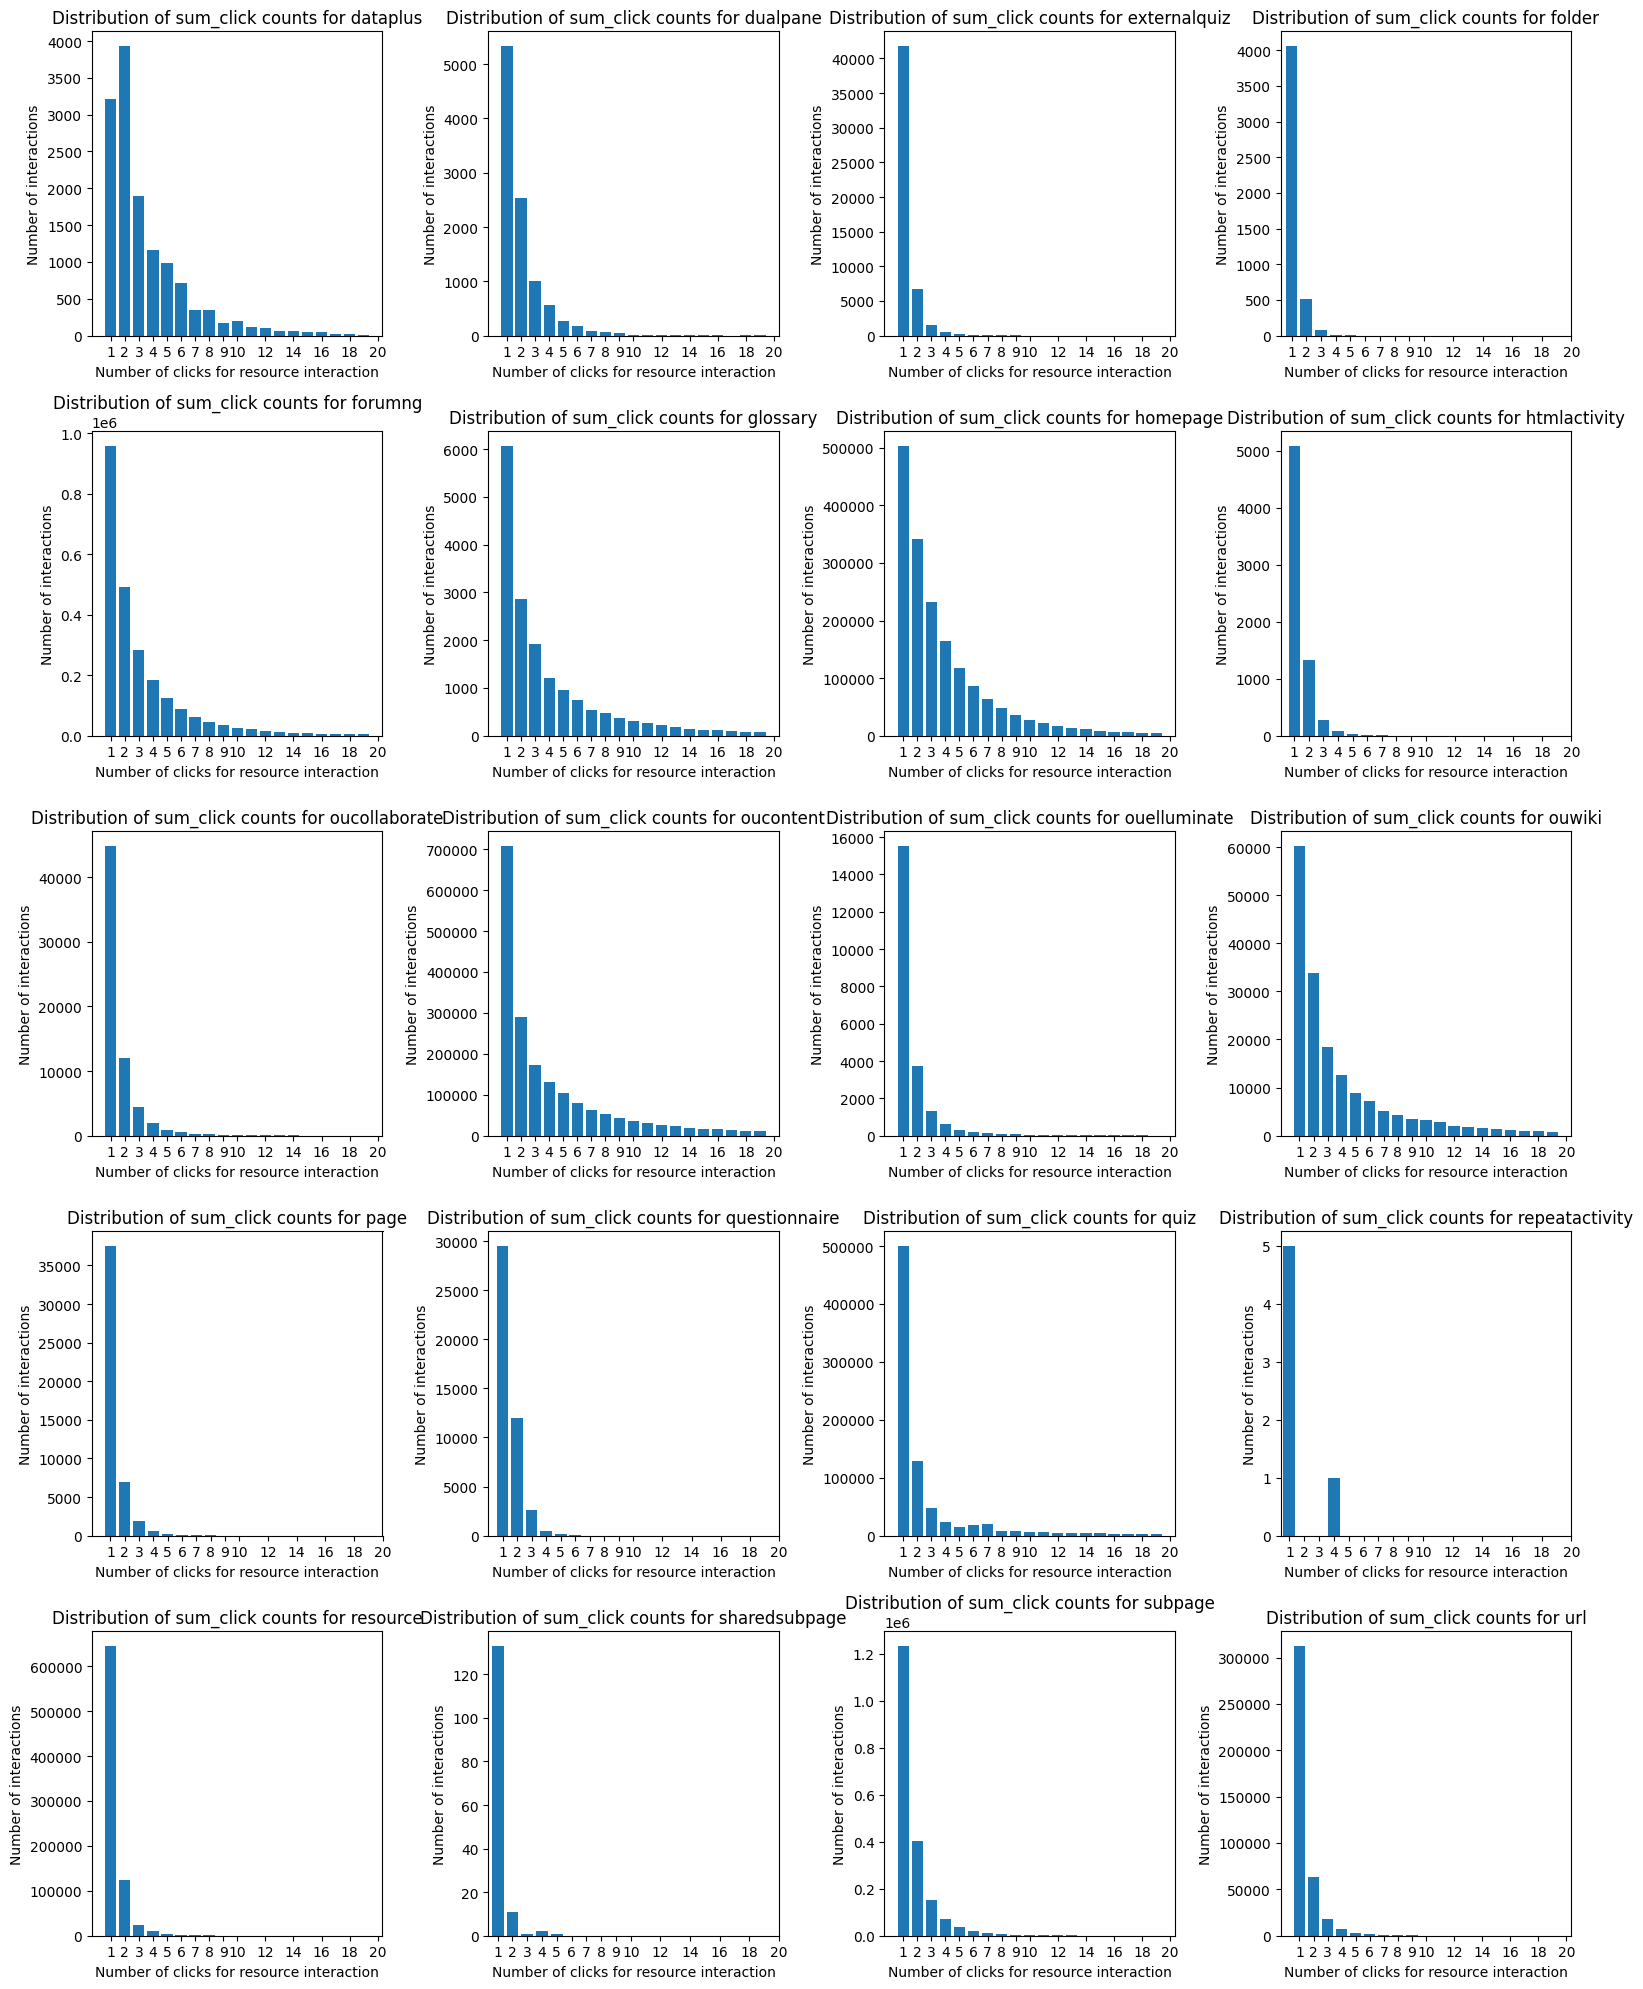

In [97]:
# check distribution of sum_click for different activity_types
include_sum_clicks_until_count = 20
plots_per_row = 4

n_plots = df_studentvle.activity_type.nunique()
n_rows = (n_plots//plots_per_row)
fig, axes = plt.subplots(n_rows, plots_per_row, figsize=(4*plots_per_row, 4*n_rows))

# delete unnecessary subplots
axes = axes.flatten()
n_surplus = n_plots%plots_per_row

if n_surplus:
    for i in range(n_surplus):
        fig.delaxes(axes[-i-1])

# Group the data by 'activity_type' and create a plot for each group
for i, (activity_type, group_data) in enumerate(df_studentvle.groupby('activity_type')):
    
    ax = axes[i]
    data = group_data['sum_click'][group_data['sum_click'] < include_sum_clicks_until_count]
    value_counts = data.value_counts().sort_index()

    ax.bar(value_counts.index, value_counts.values)
    ax.set_xticks(list(range(1, 11)) + list(range(12, include_sum_clicks_until_count + 1, 2)))

    ax.set_title(f'Distribution of sum_click counts for {activity_type}')
    ax.set_xlabel('Number of clicks for resource interaction')
    ax.set_ylabel('Number of interactions')

plt.tight_layout()

-> distribution of sum_click counts is quite different for different activity_types

# writing to csv files

Due to our denormalisation, we don't need 
- df_courses (all info in df_assessments)
- df_studentregistration (all info in df_studentinfo)

In [98]:
# rename df_studentassessment date column to due_date_assessment (!=  date of submission)
df_studentassessment.rename(columns={'date': 'due_date_assessment'}, inplace=True)

In [99]:
# write relevant dfs to csv files
folder_name = 'denormalised_data'


filenames_to_dfs = {
    'assessment': df_assessments,
    'studentassessment': df_studentassessment,
    'studentinfo': df_studentinfo,
    'studentvle': df_studentvle,
    'vle': df_vle
}

if not os.path.exists(folder_name):
    os.makedirs(folder_name)

for df_name, df in filenames_to_dfs.items():
    file_name = f'{df_name}.csv'
    file_path = os.path.join(folder_name, file_name)
    df.to_csv(file_path, index=False)